## **Algoritmo de filtraje no lineal basado en Operador de Koopman aplicado a epidemiología**

### **Capítulo 4: Algoritmo de filtraje no lineal en tiempo discreto**

**Autor: Diego Olguín.**

**Supervisores: Héctor Ramírez y Axel Osses.**

In [955]:
chapter = "chapter4/"
img_path = "img/content/"+chapter

In [956]:
# Librerías generales
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sns.set_theme()

from sklearn.gaussian_process.kernels import Matern, ConstantKernel as Cte

# Plotly
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# Librerías propias
import os

# Dependencias de KKKF
from KKKF.DynamicalSystems import DynamicalSystem
from KKKF.kEDMD import KoopmanOperator
import KKKF.applyKKKF as kkkf

# Paralelización
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

# Pandas
import pandas as pd

# Para medir el tiempo
from time import time

In [957]:
# Configuración de parámetros para Matplotlib
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'axes.titlesize': 20})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'figure.figsize': (14, 8)})
plt.rcParams.update({'figure.titlesize': 24})

In [958]:
# Ajustar directorio para las imagénes
root = "/Users/diegoolguin/Koopman_nonlinear_filter"
if not os.getcwd()==root:
    os.chdir(root)

In [959]:
# Se fija la semilla aleatoria
np.random.seed(42)

### **Comparación con el filtro de Kalman**

In [960]:
# Función que implementa el filtro de Kalman
def KalmanFilter(y, A, C, Q, R, x0, P0):
    """
    Implementación del filtro de Kalman para un sistema lineal.
    
    Args:
    y: np.array
        Observaciones del sistema.
    A: np.array
        Matriz de transición de estado.
    C: np.array
        Matriz de observación.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array 
        Covarianza del ruido de las observaciones.
    x0: np.array    
        Estado inicial.
    P0: np.array
        Covarianza inicial.

    Returns:
    x: np.array
        Estados estimados.
    P: np.array
        Covarianza de los estados estimados.
    """

    # Número de observaciones
    iters = y.shape[1]
    
    # Inicialización de los vectores de estado y covarianza
    x = np.zeros((A.shape[0], iters))
    P = np.zeros((A.shape[0], A.shape[0], iters))
    
    # Inicialización de los estados y covarianza iniciales
    x[:, 0] = x0
    P[:, :, 0] = P0
    
    # Iteración del filtro
    for i in range(1, iters):
        # Predicción
        x[:, i] = A @ x[:, i-1]
        P[:, :, i] = A @ P[:, :, i-1] @ A.T + Q
        
        # Actualización
        K = P[:, :, i] @ C.T @ np.linalg.inv(C @ P[:, :, i] @ C.T + R)
        x[:, i] = x[:, i] + K @ (y[:, i] - C @ x[:, i])
        P[:, :, i] = P[:, :, i] - K @ C @ P[:, :, i]
    
    return x, P

In [974]:
# Función para comparar los resultados del filtro de Kalman y el filtro no lineal
def compare_linear_filters(x0, x0_prior, A, C, Q, R, k, N, iters, optimize=True):
    """
    Función que compara los resultados del filtro de Kalman y el filtro no lineal.
    
    Args:
    x0: np.array
        Condición inicial verdadera.
    x0_prior: rv_continuous
        Distribución para el estado inicial
    A: np.array
        Matriz de transición de estado.
    C: np.array
        Matriz de observación.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array
        Covarianza del ruido de las observaciones.
    k: Kernel
        Kernel para el operador de Koopman.
    N: int
        Dimensión de aproximación de Koopman
    iters: int
        Número de iteraciones.
    optimize: bool
        Indica si se optimiza el kernel en kEDMD

    Returns:
    x: np.array
        Estados verdaderos del sistema.
    x_kalman: np.array
        Estados estimados por el filtro de Kalman.
    x_kkkf: np.array
        Estados estimados por el filtro no lineal.
    """
    # Funciones de dinámica y observación
    f = lambda x: A @ x
    g = lambda x: C @ x

    # Dimensiones
    nx, ny = A.shape[0], C.shape[0]

    # Distribuciones
    X_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=5*np.eye(nx))
    dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
    obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)

    # Sistema dinámico
    dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

    # Operador de Koopman
    koopman = KoopmanOperator(kernel_function=k, dynamical_system=dyn)

    # Trayectoria real y observaciones
    x = np.zeros((nx, iters))
    y = np.zeros((ny, iters))
    x[:, 0] = x0
    for i in range(1, iters):
        x[:, i] = A @ x[:, i-1] 
        y[:, i] = C @ x[:, i] + np.random.multivariate_normal(np.zeros(ny), R)

    # Inicialización de las covarianzas iniciales
    P0 = x0_prior.cov

    # Filtro de Kalman
    x_kalman, P_kalman = KalmanFilter(y, A, C, Q, R, x0_prior.mean, P0)

    # Filtro no lineal
    sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N, optimize=optimize)
    x_kkkf, P_kkkf = sol_kkkf.x_plus.T, sol_kkkf.Px_plus

    return x, x_kalman, x_kkkf

In [975]:
# Condición inicial real
x0 = np.array([1, 1, 1])

# Condición inicial prior
x0_prior = stats.multivariate_normal(mean=np.array([0.8, 1.2, 0.9]), cov=0.01*np.eye(3))

# Función para crear matrices de transición
A_fun = lambda alpha: np.array(
    [
        [1.01, 0.01, 0.0],
        [0.01, 1.02, alpha],
        [0.0, 0.04, 1.02]
    ]
)

# Matriz de observación
C = np.array([
    [1, 0, 0],
    [0, 1, 0],
])

# Dimensiones
nx, ny = len(x0), C.shape[0]

# Covarianzas del ruido
Q = 0.01*np.eye(nx)
R = 0.01*np.eye(ny)

# Número de dimensiones de aproximación
N = 500

# Número de iteraciones
iters = 30

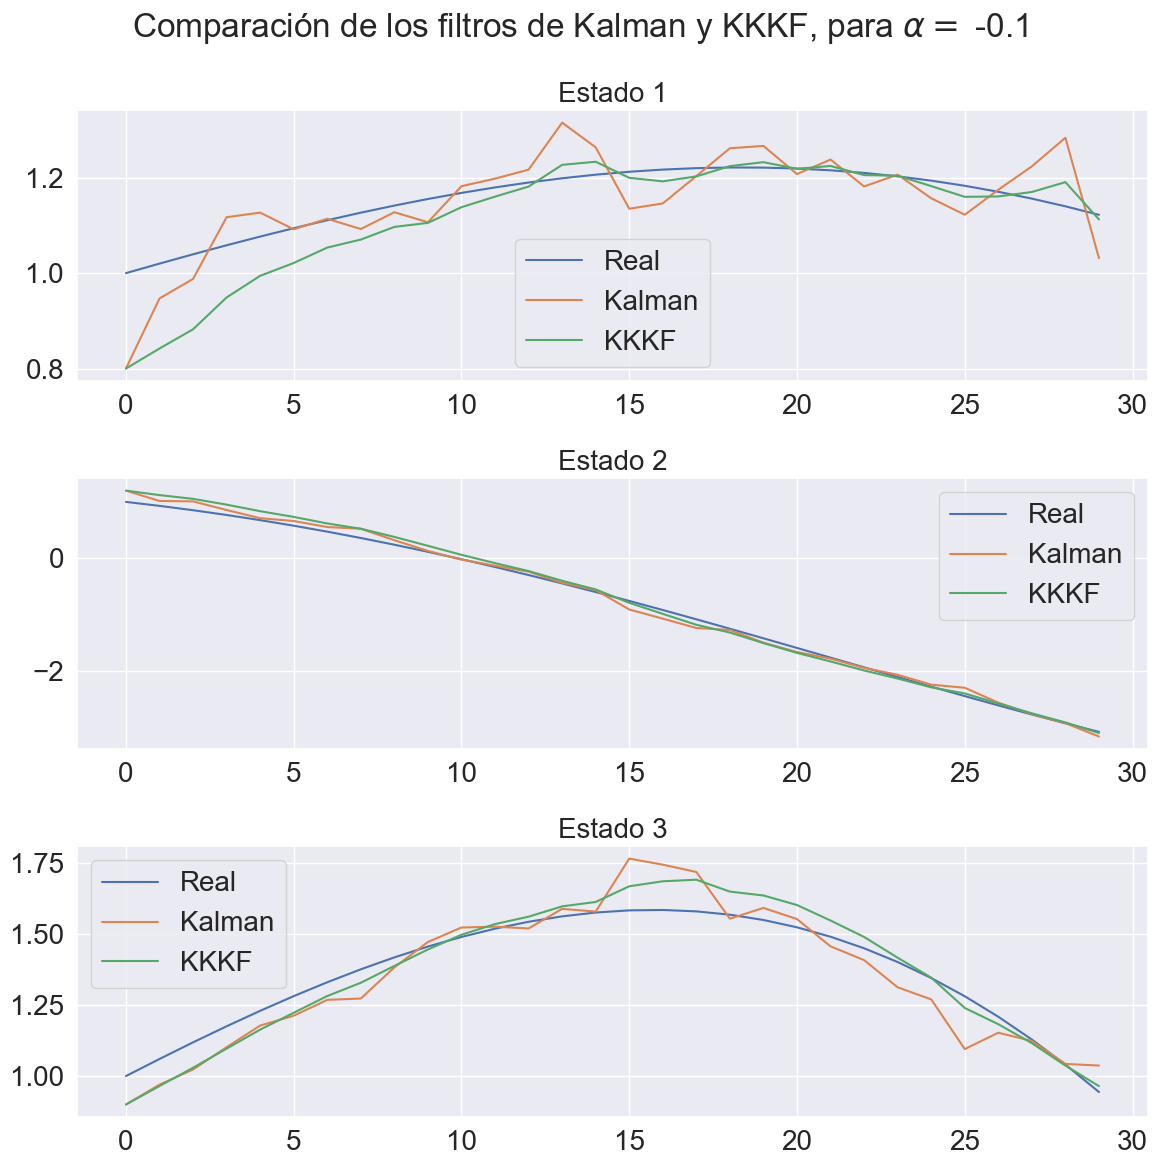

In [976]:
# Kernel
k = Cte(1.0, (1e-5, 1e5)) * Matern(length_scale=1e2, nu=1.5)

# Comparación de los filtros
alpha = -0.1
A = A_fun(alpha)
x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, k, N, iters, optimize=False)

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], label='Real')
ax[0].plot(x_kalman[0, :], label='Kalman')
ax[0].plot(x_kkkf[0, :], label='KKKF')
ax[0].set_title('Estado 1')
ax[0].legend()

ax[1].plot(x[1, :], label='Real')
ax[1].plot(x_kalman[1, :], label='Kalman')
ax[1].plot(x_kkkf[1, :], label='KKKF')
ax[1].set_title('Estado 2')
ax[1].legend()

ax[2].plot(x[2, :], label='Real')
ax[2].plot(x_kalman[2, :], label='Kalman')
ax[2].plot(x_kkkf[2, :], label='KKKF')
ax[2].set_title('Estado 3')
ax[2].legend()

plt.suptitle(r'Comparación de los filtros de Kalman y KKKF, para $\alpha=$ {}'.format(alpha))
plt.tight_layout()
plt.savefig(img_path+'kalman_kkkf_01.pdf')
plt.show()

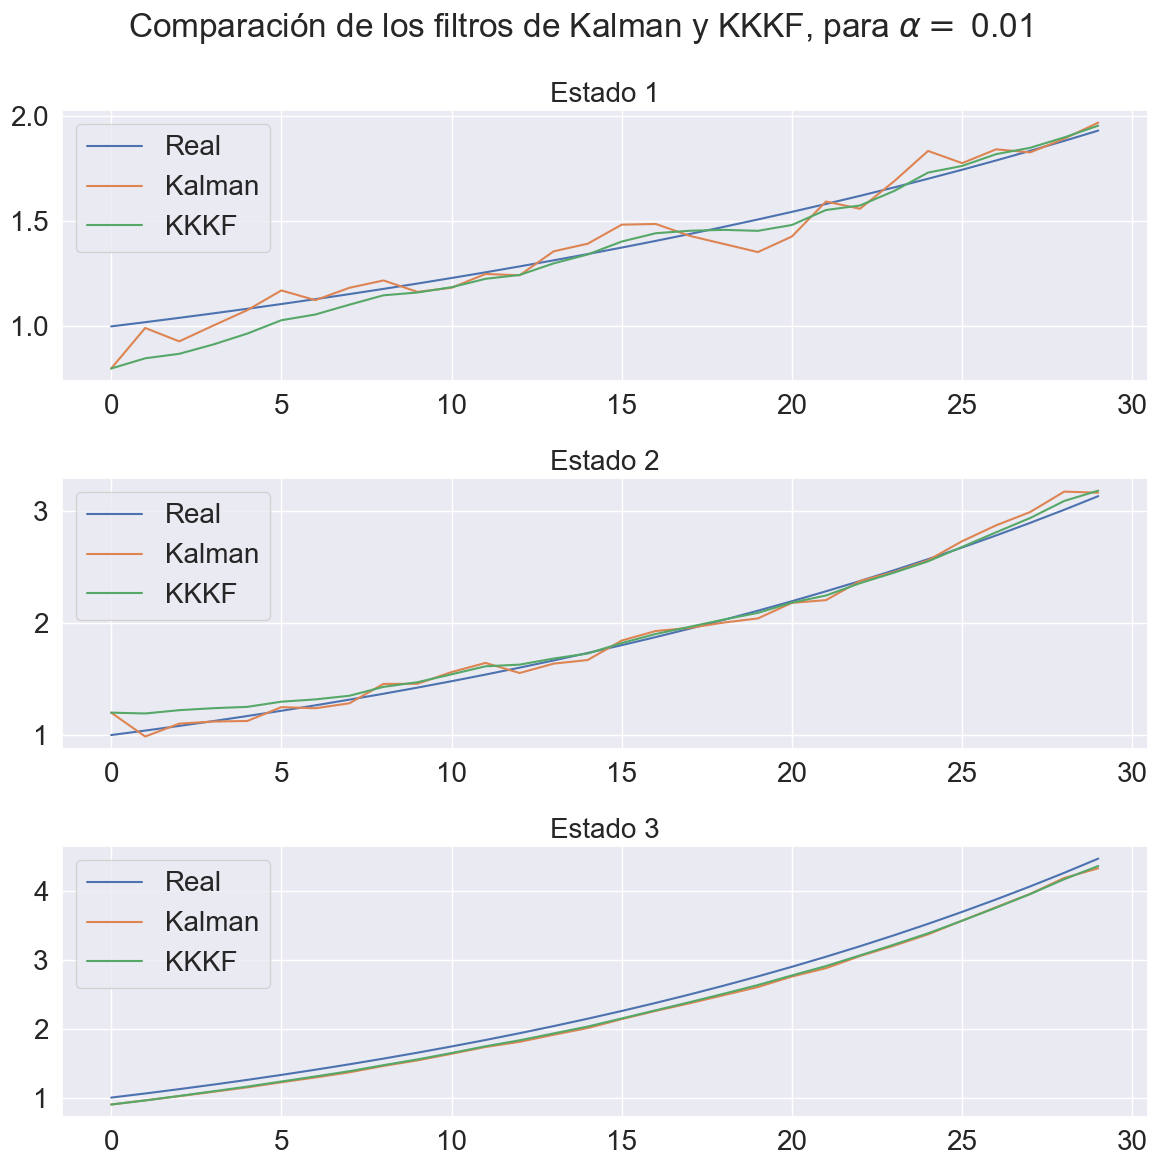

In [977]:
# Kernel
k = Cte(1.0, (1e-5, 1e5)) * Matern(length_scale=1e2, nu=1.5)

# Comparación de los filtros
alpha = 0.01
A = A_fun(alpha)
x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, k, N, iters, optimize=False)

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], label='Real')
ax[0].plot(x_kalman[0, :], label='Kalman')
ax[0].plot(x_kkkf[0, :], label='KKKF')
ax[0].set_title('Estado 1')
ax[0].legend()

ax[1].plot(x[1, :], label='Real')
ax[1].plot(x_kalman[1, :], label='Kalman')
ax[1].plot(x_kkkf[1, :], label='KKKF')
ax[1].set_title('Estado 2')
ax[1].legend()

ax[2].plot(x[2, :], label='Real')
ax[2].plot(x_kalman[2, :], label='Kalman')
ax[2].plot(x_kkkf[2, :], label='KKKF')
ax[2].set_title('Estado 3')
ax[2].legend()

plt.suptitle(r'Comparación de los filtros de Kalman y KKKF, para $\alpha=$ {}'.format(alpha))
plt.tight_layout()
plt.savefig(img_path+'kalman_kkkf_001.pdf')
plt.show()

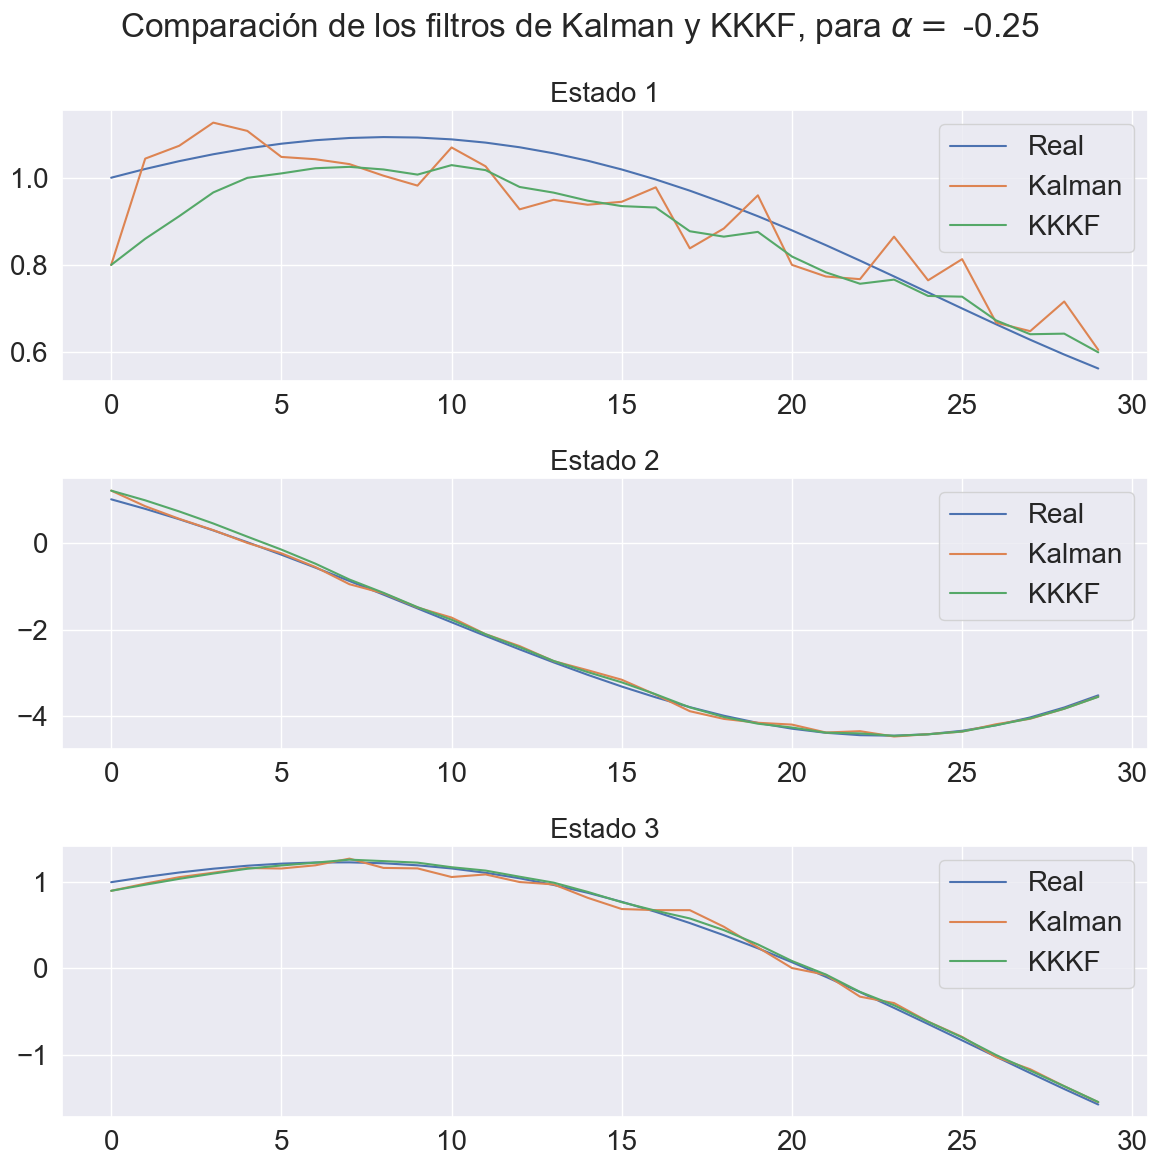

In [978]:
# Kernel
k = Matern(length_scale=1e2, nu=1.5)

# Comparación de los filtros
alpha = -0.25
A = A_fun(alpha)
x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, k, N, iters, optimize=False)

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], label='Real')
ax[0].plot(x_kalman[0, :], label='Kalman')
ax[0].plot(x_kkkf[0, :], label='KKKF')
ax[0].set_title('Estado 1')
ax[0].legend()

ax[1].plot(x[1, :], label='Real')
ax[1].plot(x_kalman[1, :], label='Kalman')
ax[1].plot(x_kkkf[1, :], label='KKKF')
ax[1].set_title('Estado 2')
ax[1].legend()

ax[2].plot(x[2, :], label='Real')
ax[2].plot(x_kalman[2, :], label='Kalman')
ax[2].plot(x_kkkf[2, :], label='KKKF')
ax[2].set_title('Estado 3')
ax[2].legend()

plt.suptitle(r'Comparación de los filtros de Kalman y KKKF, para $\alpha=$ {}'.format(alpha))
plt.tight_layout()
plt.savefig(img_path+'kalman_kkkf_025.pdf')
plt.show()

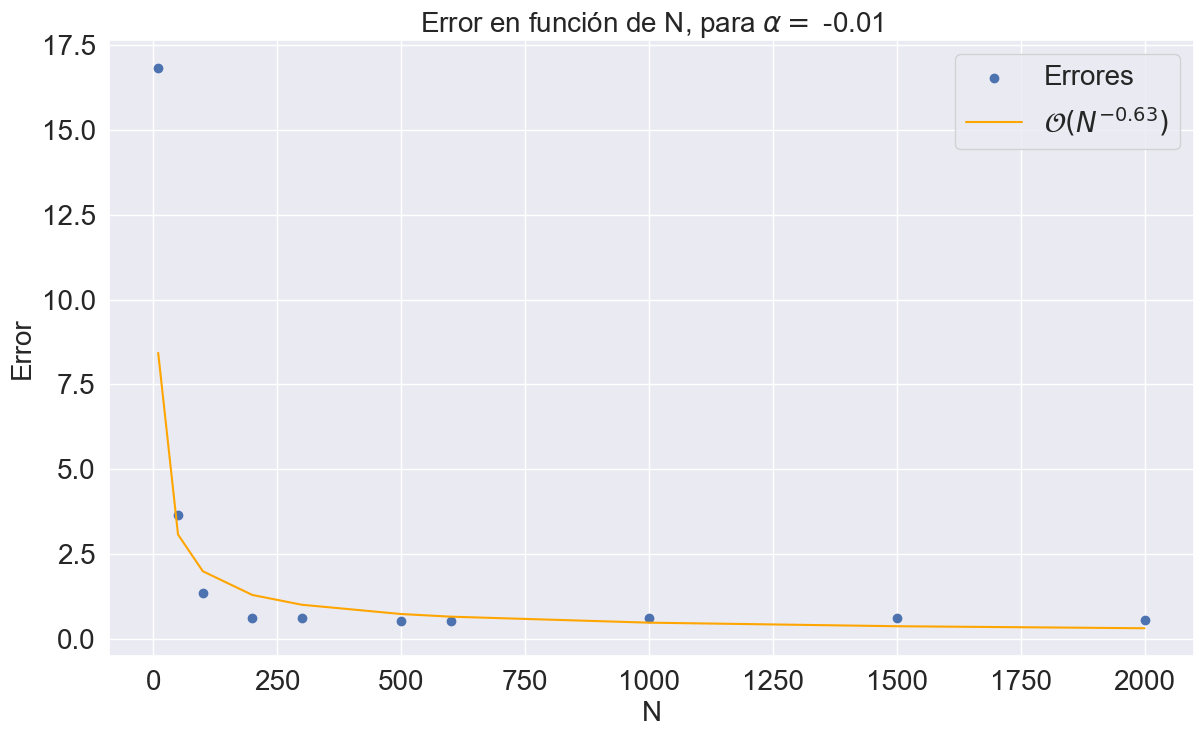

In [984]:
np.random.seed(42)

# Calcular errores
alpha = -0.01
A = A_fun(alpha)

Ns = [10, 50, 100, 200, 300, 500, 600, 1000, 1500, 2000]

errors_kalman = []

for N in Ns:
    # Kernel
    k = Cte(1.0, (1e-5, 1e5)) * Matern(length_scale=N**(2/3), nu=0.5)
    x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, k, N, iters, optimize=False)
    errors_kalman.append(np.linalg.norm(x_kalman - x_kkkf))

# Ajustar una curva C*N**alpha
p = np.polyfit(np.log(Ns), np.log(errors_kalman), 1)

plt.scatter(Ns, errors_kalman, label='Errores')
plt.plot(Ns, np.exp(p[1])*Ns**p[0], label=r'$\mathcal{O}(N^{%.2f})$' % p[0], c='orange')
plt.xlabel('N')
plt.ylabel('Error')
plt.title(r'Error en función de N, para $\alpha=$ {}'.format(alpha))
plt.savefig(img_path+'linear_error_01.pdf')
plt.legend()

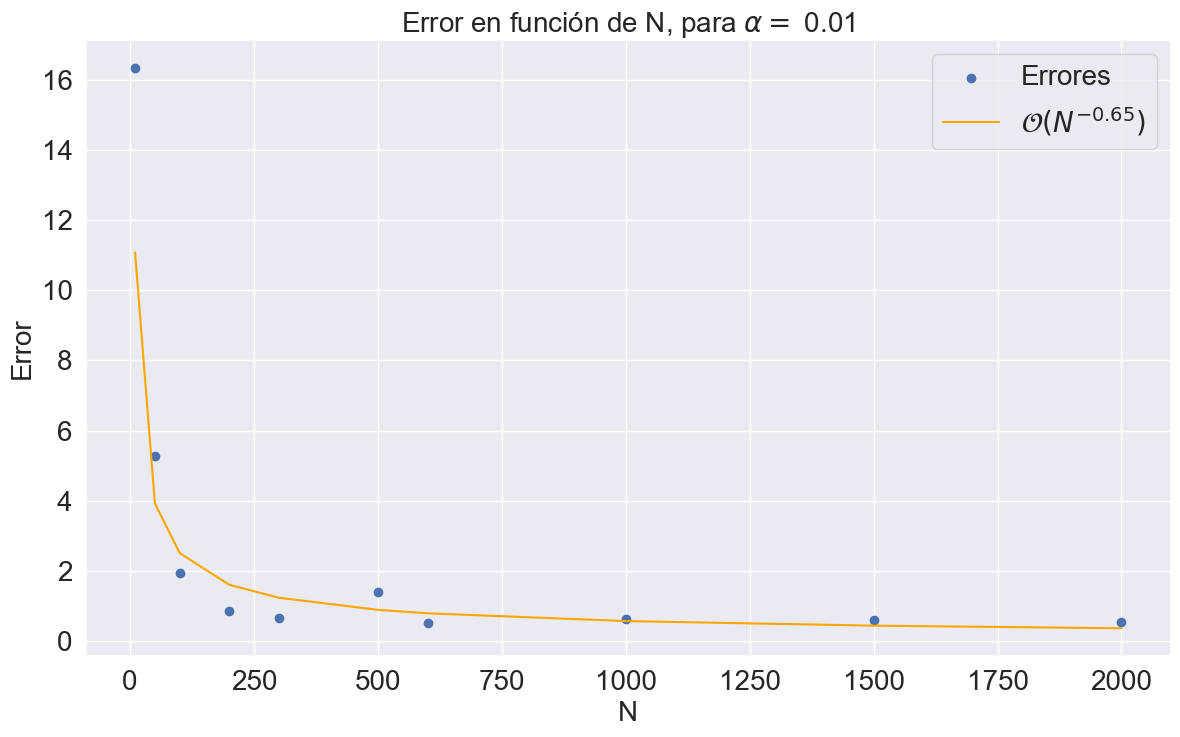

In [986]:
np.random.seed(42)

# Calcular errores
alpha = 0.01
A = A_fun(alpha)

Ns = [10, 50, 100, 200, 300, 500, 600, 1000, 1500, 2000]

errors_kalman = []

for N in Ns:
    # Kernel
    k = Cte(1.0, (1e-5, 1e5)) * Matern(N**(2/3), nu=0.5)
    x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, k, N, iters, optimize=False)
    errors_kalman.append(np.linalg.norm(x_kalman - x_kkkf))

# Ajustar una curva C*N**alpha
p = np.polyfit(np.log(Ns), np.log(errors_kalman), 1)

plt.scatter(Ns, errors_kalman, label='Errores')
plt.plot(Ns, np.exp(p[1])*Ns**p[0], label=r'$\mathcal{O}(N^{%.2f})$' % p[0], c='orange')
plt.xlabel('N')
plt.ylabel('Error')
plt.title(r'Error en función de N, para $\alpha=$ {}'.format(alpha))
plt.savefig(img_path+'linear_error_001.pdf')
plt.legend()

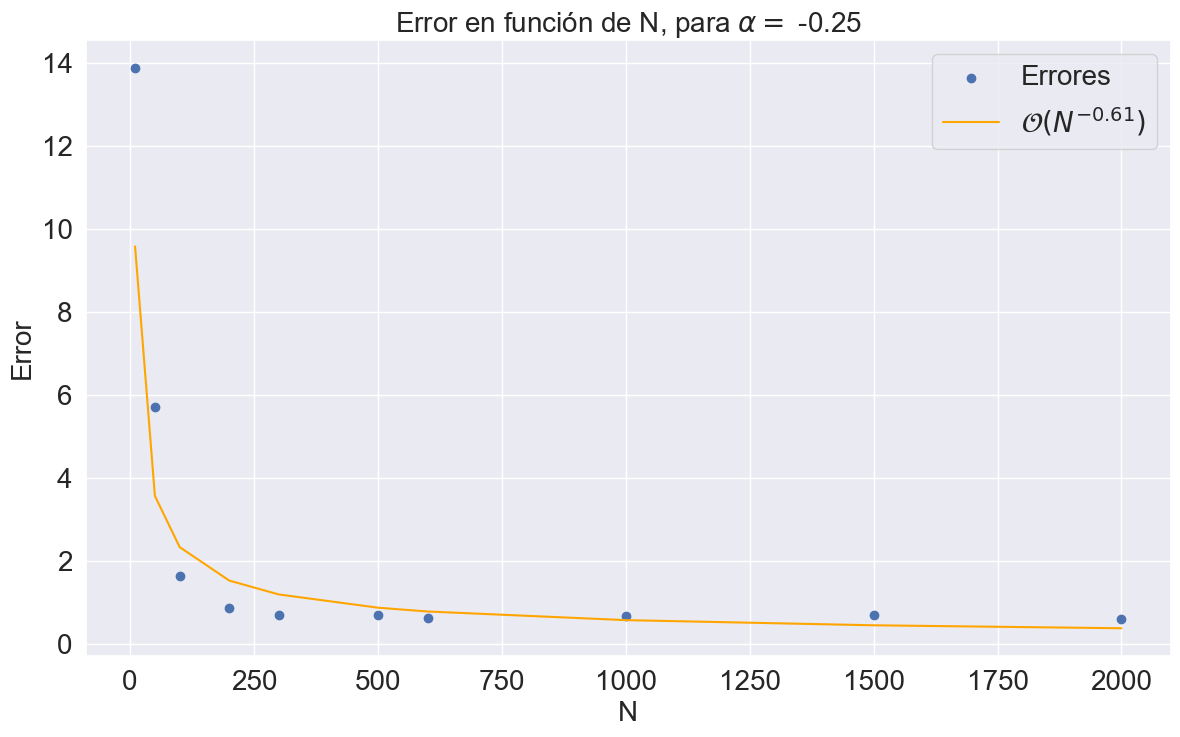

In [987]:
np.random.seed(42)

# Calcular errores
alpha = -0.25
A = A_fun(alpha)

Ns = [10, 50, 100, 200, 300, 500, 600, 1000, 1500, 2000]

errors_kalman = []

for N in Ns:
    k = Matern(length_scale=N**(2/3), nu=0.5)
    x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, k, N, iters, optimize=False)
    errors_kalman.append(np.linalg.norm(x_kalman - x_kkkf))

# Ajustar una curva C*N**alpha
p = np.polyfit(np.log(Ns), np.log(errors_kalman), 1)

plt.scatter(Ns, errors_kalman, label='Errores')
plt.plot(Ns, np.exp(p[1])*Ns**p[0], label=r'$\mathcal{O}(N^{%.2f})$' % p[0], c='orange')
plt.xlabel('N')
plt.ylabel('Error')
plt.title(r'Error en función de N, para $\alpha=$ {}'.format(alpha))
plt.savefig(img_path+'linear_error_025.pdf')
plt.legend()

### **Filtraje para el modelo SIR**

In [15]:
# Función para calcular el jacobiano 
def jacobian(f, x, tol=1e-6):
    """
    Función que calcula el jacobiano de una función en un punto.

    Args:
    f: function
        Función a evaluar.
    x: np.array
        Punto de evaluación.
    tol: float
        Tolerancia para la aproximación de las derivadas.

    Returns:
    J: np.array
        Jacobiano de la función en el punto dado.
    """
    nx = x.shape[0]
    nf = f(x).shape[0]
    J = np.zeros((nf, nx))
    for i in range(nx):
        e = np.zeros(nx)
        e[i] = 1
        J[:, i] = (f(x + tol*e) - f(x - tol*e))/(2*tol)
    return J

In [16]:
# Función que implementa el filtro de Kalman extendido
def ExtendedKalmanFilter(y, f, g, Q, R, x0, P0):
    """
    Implementación del filtro de Kalman extendido para un sistema no lineal.
    
    Args:
    y: np.array
        Observaciones del sistema.
    f: function
        Función de dinámica.
    g: function
        Función de observación.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array 
        Covarianza del ruido de las observaciones.
    x0: np.array
        Estado inicial.
    P0: np.array    
        Covarianza inicial.

    Returns:
    x: np.array
        Estados estimados.
    P: np.array
        Covarianza de los estados estimados.
    """

    # Número de observaciones
    iters = y.shape[1]

    # Dimensiones
    nx, ny = len(x0), len(y[:,0])
    
    # Inicialización de los vectores de estado y covarianza
    x = np.zeros((iters, nx))
    P = np.zeros((iters, nx, nx))
    
    # Inicialización de los estados y covarianza iniciales
    x[0, :] = x0
    P[0, :, :] = P0
    
    # Iteración del filtro
    for i in range(1, iters):
        # Predicción
        x[i, :] = f(x[i-1, :])
        F = jacobian(f, x[i-1, :])
        P[i, :, :] = F @ P[i-1, :, :] @ F.T + Q
        
        # Actualización
        H = jacobian(g, x[i, :])
        K = P[i, :, :] @ H.T @ np.linalg.inv(H @ P[i, :, :] @ H.T + R)
        x[i, :] = x[i, :] + K @ (y[:, i] - g(x[i, :]))
        P[i, :, :] = P[i, :, :] - K @ H @ P[i, :, :]
    
    return x, P

In [17]:
# Función para calcular los sigma points del Unscented Kalman Filter
def compute_sigma_points(x, P, alpha, beta, kappa):
    """
    Función que calcula los sigma points para el Unscented Kalman Filter.

    Args:
    x: np.array
        Estado.
    P: np.array
        Covarianza.
    alpha: float
        Parámetro de ajuste.
    beta: float
        Parámetro de ajuste.
    kappa: float
        Parámetro de ajuste.

    Returns:
    sigma_points: np.array
        Sigma points.
    Wm: np.array
        Pesos para la media.
    Wc: np.array
        Pesos para la covarianza.
    """

    nx = len(x)
    lambda_ = alpha**2 * (nx + kappa) - nx
    sigma_points = np.zeros((2 * nx + 1, nx))
    Wm = np.zeros(2 * nx + 1)
    Wc = np.zeros(2 * nx + 1)
    U = np.linalg.cholesky((lambda_ + nx) * P)
    sigma_points[0] = x
    Wm[0] = lambda_ / (nx + lambda_)
    Wc[0] = lambda_ / (nx + lambda_) + (1 - alpha**2 + beta)
    for i in range(nx):
        sigma_points[i + 1] = x + U[i]
        sigma_points[nx + i + 1] = x - U[i]
        Wm[i + 1] = Wm[nx + i + 1] = 1 / (2 * (nx + lambda_))
        Wc[i + 1] = Wc[nx + i + 1] = 1 / (2 * (nx + lambda_))
    return sigma_points, Wm, Wc

# Función que implementa Unscented Kalman Filter
def UnscentedKalmanFilter(y, f, g, Q, R, x0, P0, alpha=1e-3, beta=2, kappa=0):
    """
    Implementación del Unscented Kalman Filter para un sistema no lineal.
    
    Args:
    y: np.array
        Observaciones del sistema.
    f: function
        Función de dinámica.
    g: function
        Función de observación.
    Q: np.array 
        Covarianza del ruido del sistema.
    R: np.array
        Covarianza del ruido de las observaciones.
    x0: np.array
        Estado inicial.
    P0: np.array
        Covarianza inicial.

    Returns:
    x: np.array
        Estados estimados.
    P: np.array
        Covarianza de los estados estimados.
    """

    nx = len(x0)
    x_est = np.zeros((len(y), nx))
    P_est = np.zeros((len(y), nx, nx))
    x_est[0] = x0
    P_est[0] = P0
    x = x0
    P = P0

    for k in range(1, len(y)):
        # Generar los sigma points
        sigma_points, Wm, Wc = compute_sigma_points(x, P, alpha, beta, kappa)

        # Predicción
        sigma_points_pred = np.array([f(sp) for sp in sigma_points])
        x_pred = np.dot(Wm, sigma_points_pred)
        P_pred = Q + sum(Wc[i] * np.outer(sigma_points_pred[i] - x_pred, sigma_points_pred[i] - x_pred) for i in range(2 * nx + 1))

        # Acutualización
        sigma_points_meas = np.array([g(sp) for sp in sigma_points_pred])
        y_pred = np.dot(Wm, sigma_points_meas)
        P_zz = R + sum(Wc[i] * np.outer(sigma_points_meas[i] - y_pred, sigma_points_meas[i] - y_pred) for i in range(2 * nx + 1))
        P_xz = sum(Wc[i] * np.outer(sigma_points_pred[i] - x_pred, sigma_points_meas[i] - y_pred) for i in range(2 * nx + 1))
        K = np.dot(P_xz, np.linalg.inv(P_zz))
        x = x_pred + np.dot(K, y[k] - y_pred)
        P = P_pred - np.dot(K, np.dot(P_zz, K.T))

        x_est[k] = x
        P_est[k] = P

    return x_est, P_est

In [18]:
# Función para implementar un filtro de partículas
def ParticleFilter(y, f, g, Q, R, x0, P0):
    """
    Implementación de un filtro de partículas para un sistema no lineal.
    
    Args:
    y: np.array
        Observaciones del sistema.
    f: function
        Función de dinámica.
    g: function
        Función de observación.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array
        Covarianza del ruido de las observaciones.
    x0: np.array
        Estado inicial.
    P0: np.array
        Covarianza inicial.

    Returns:
    x: np.array
        Estados estimados.
    P: np.array
        Covarianza de los estados estimados.
    """

    nx = len(x0)
    N = 1000
    x_est = np.zeros((len(y), nx))
    P_est = np.zeros((len(y), nx, nx))
    x_est[0] = x0
    P_est[0] = P0
    particles = np.random.multivariate_normal(x0, P0, N)
    weights = np.ones(N) / N

    for k in range(1, len(y)):
        # Predicción
        particles = np.array([f(p) + np.random.multivariate_normal(np.zeros(nx), Q) for p in particles])

        # Pesos
        weights = np.array([stats.multivariate_normal(g(p), R).pdf(y[k]) for p in particles])
        weights = weights / np.sum(weights)

        # Resampling
        idx = np.random.choice(N, N, p=weights)
        particles = particles[idx]

        # Estimación
        x_est[k] = np.mean(particles, axis=0)
        P_est[k] = np.cov(particles.T)

    return x_est

In [19]:
# Función para comparar los resultados del filtro de Kalman y el filtro no lineal
def compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters):
    """
    Función que compara los resultados de EKF, UKF y KKKF.
    
    Args:
    x0: np.array
        Condición inicial verdadera.
    x0_prior: rv_continuous
        Distribución para el estado inicial
    f: function
        Función de dinámica.
    g: function
        Función de observación.
    X_dist: rv_continuous
        Distribución de los estados.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array
        Covarianza del ruido de las observaciones.
    N: int
        Dimensión de aproximación de Koopman
    iters: int
        Número de iteraciones.

    Returns:
    x: np.array
        Estados verdaderos del sistema.
    x_ekf: np.array
        Estados estimados por EKF.
    x_ukf: np.array
        Estados estimados por UKF.
    x_kkkf: np.array
        Estados estimados por KKKF.
    """

    # Dimensiones
    nx, ny = f(x0).shape[0], g(x0).shape[0]

    # Distribuciones
    dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
    obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)

    # Sistema dinámico
    dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

    # Operador de Koopman
    koopman = KoopmanOperator(kernel_function=Matern(length_scale=1e3, nu=0.5), dynamical_system=dyn)

    # Trayectoria real y observaciones
    x = np.zeros((nx, iters))
    y = np.zeros((ny, iters))
    x[:, 0] = x0
    for i in range(1, iters):
        x[:, i] = f(x[:, i-1]) 
        y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    # Inicialización de las covarianzas iniciales
    P0 = x0_prior.cov

    # EKF
    x_ekf, P_ekf = ExtendedKalmanFilter(y, f, g, Q, R, x0_prior.mean, P0)

    # UKF
    x_ukf, P_ukf = UnscentedKalmanFilter(y.T, f, g, Q, R, x0_prior.mean, P0)

    # PF
    x_pf = ParticleFilter(y.T, f, g, Q, R, x0_prior.mean, P0)

    # KKF
    sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)
    x_kkkf, P_kkkf = sol_kkkf.x_plus.T, sol_kkkf.Px_plus

    return x, x_ekf, x_ukf, x_pf, x_kkkf

In [20]:
# Función de observación
g = lambda x: np.array([x[1]])

# Condición inicial real
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Condición inicial prior
x0_prior = stats.multivariate_normal(mean=np.array([0.9, 0.05, 0.05]), cov=0.01*np.eye(nx))

# Distribuciones
X_dist = stats.dirichlet(alpha=np.array([1, 1, 1])) 

# Número de dimensiones de aproximación
N = 1000

# Número de iteraciones
iters = 20

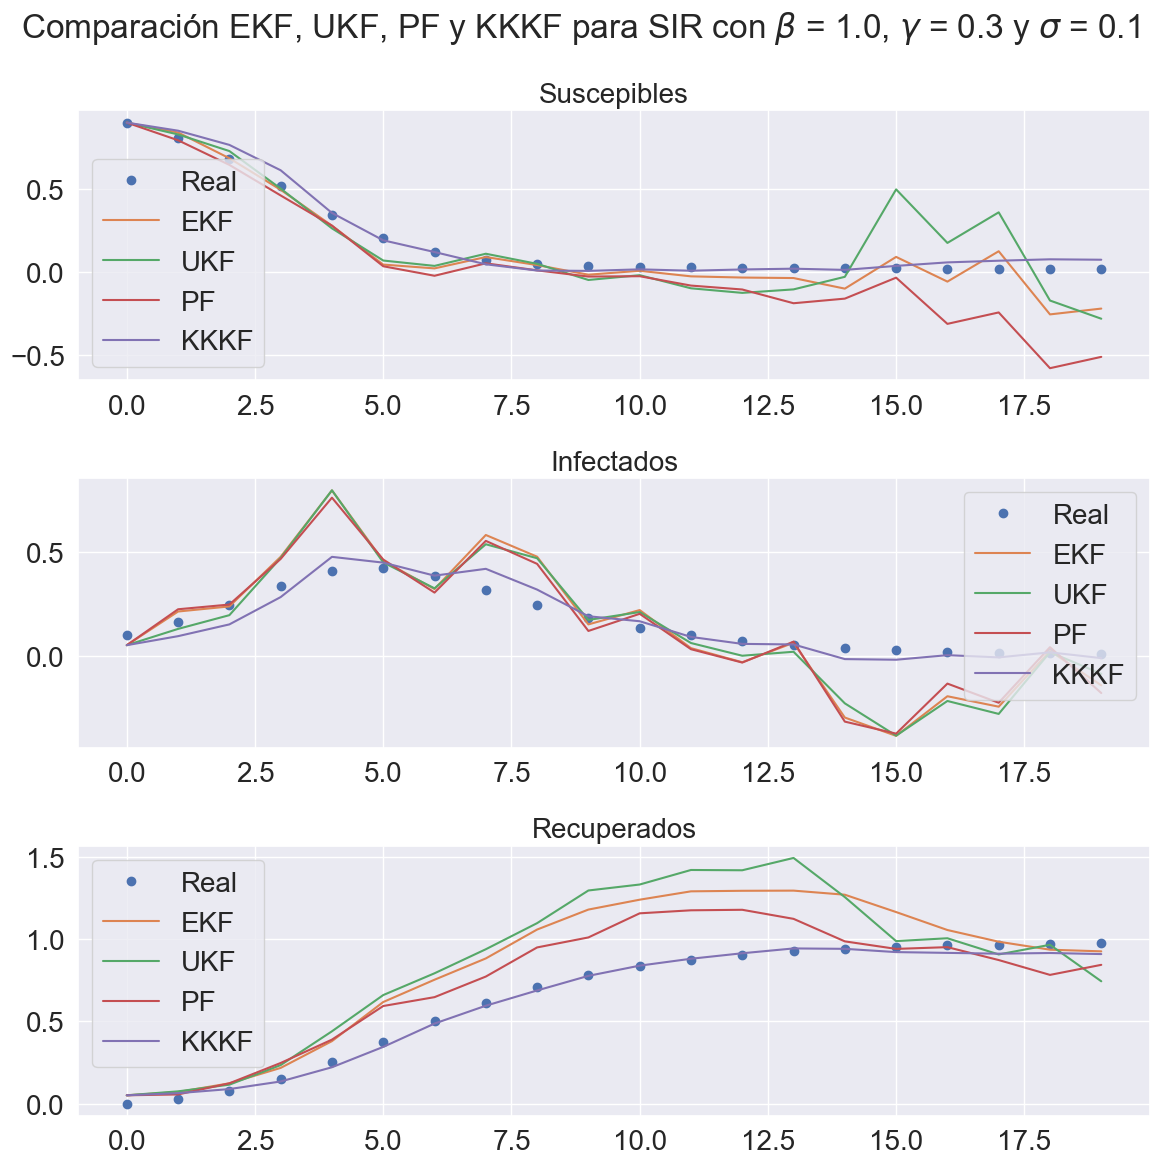

In [21]:
# Testeo para modelo SIR

np.random.seed(42)

# Covarianzas del ruido
sigma = 0.1
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 1.
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_pf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_pf[:, 0], label='PF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_pf[:, 1], label='PF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_pf[:, 2], label='PF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()
plt.suptitle(r'Comparación EKF, UKF, PF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_sigma_01.pdf')

In [22]:
# Calcular el error de cada filtro
print('Error EKF')
print(f"S: {np.linalg.norm(x_ekf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ekf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ekf[:, 2] - x[2, :])}")
print('')

print('Error UKF')
print(f"S: {np.linalg.norm(x_ukf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ukf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ukf[:, 2] - x[2, :])}")
print('')

print('Error PF')
print(f"S: {np.linalg.norm(x_pf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_pf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_pf[:, 2] - x[2, :])}")
print('')

print('Error KKKF')
print(f"S: {np.linalg.norm(x_kkkf.T[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_kkkf.T[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_kkkf.T[:, 2] - x[2, :])}")


Error EKF
S: 0.47572260045074616
I: 0.8664900694725245
R: 1.136037745264566

Error UKF
S: 0.7738002591967432
I: 0.8299530597167741
R: 1.4221016708827852

Error PF
S: 1.001920765173239
I: 0.8272413611110461
R: 0.7803082527173147

Error KKKF
S: 0.1814518895854193
I: 0.21847171522439904
R: 0.14315263149906984


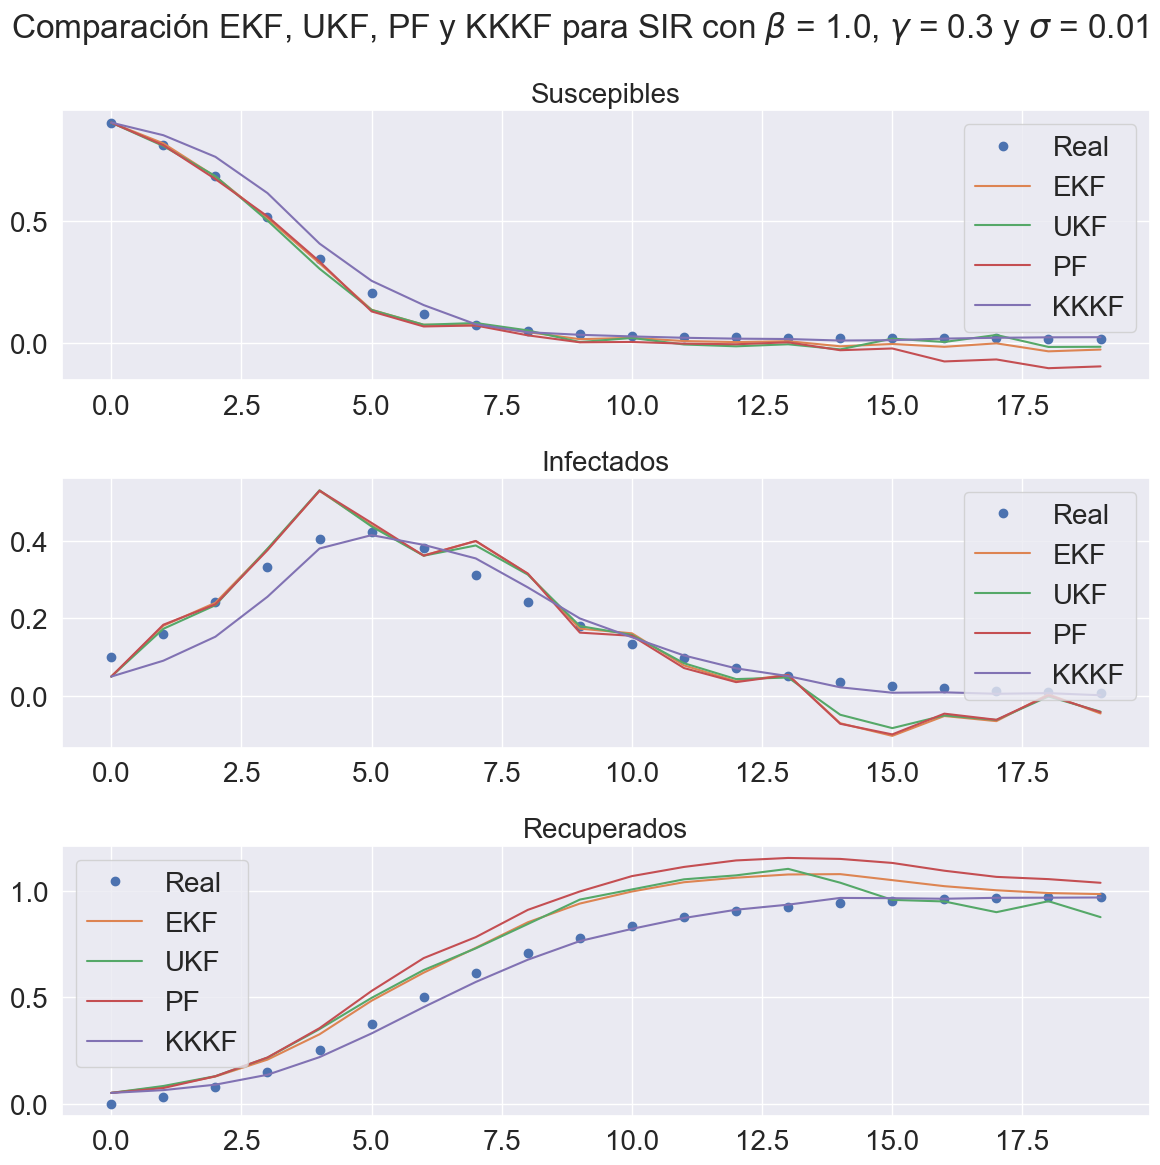

In [23]:
# Testeo para modelo SIR

np.random.seed(42)

# Covarianzas del ruido
sigma = 0.01
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 1.
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_pf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_pf[:, 0], label='PF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_pf[:, 1], label='PF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_pf[:, 2], label='PF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()

plt.suptitle(r'Comparación EKF, UKF, PF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_sigma_001.pdf')

In [24]:
# Calcular el error de cada filtro
print('Error EKF')
print(f"S: {np.linalg.norm(x_ekf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ekf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ekf[:, 2] - x[2, :])}")
print('')

print('Error UKF')
print(f"S: {np.linalg.norm(x_ukf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ukf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ukf[:, 2] - x[2, :])}")
print('')

print('Error PF')
print(f"S: {np.linalg.norm(x_pf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_pf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_pf[:, 2] - x[2, :])}")
print('')

print('Error KKKF')
print(f"S: {np.linalg.norm(x_kkkf.T[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_kkkf.T[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_kkkf.T[:, 2] - x[2, :])}")


Error EKF
S: 0.12770369755414882
I: 0.2800833271859978
R: 0.48807148038490106

Error UKF
S: 0.1327871288202395
I: 0.2564762143959351
R: 0.5134786160879233

Error PF
S: 0.2457850714973757
I: 0.27777969157765586
R: 0.7307361781179676

Error KKKF
S: 0.15947441040265228
I: 0.1629321993523519
R: 0.11449384558176537


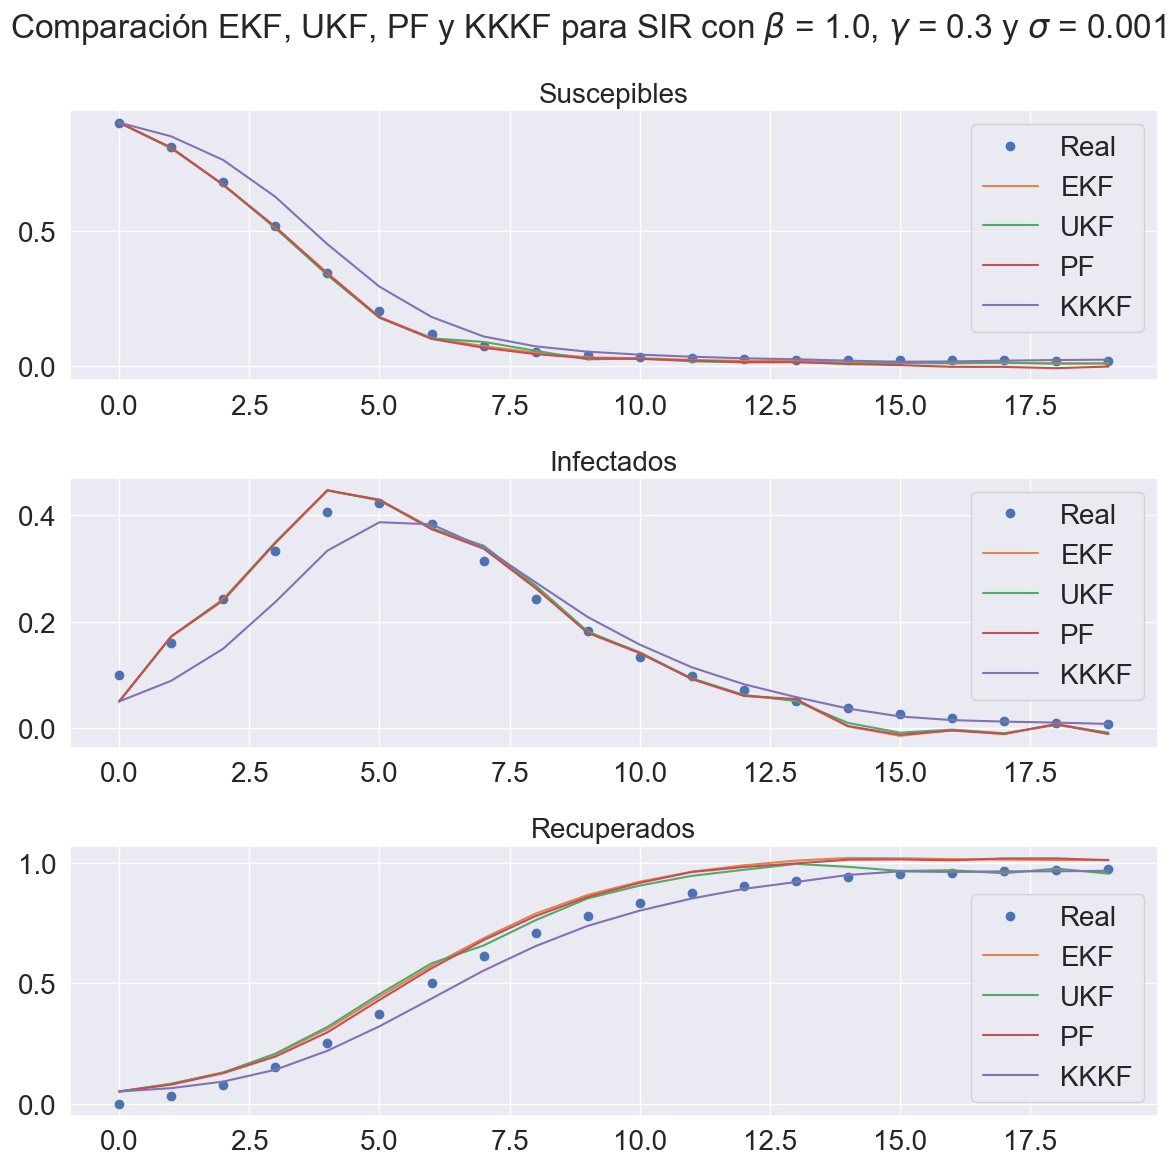

In [25]:
# Testeo para modelo SIR

np.random.seed(42)

# Covarianzas del ruido
sigma = 0.001
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 1.
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_pf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_pf[:, 0], label='PF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_pf[:, 1], label='PF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_pf[:, 2], label='PF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()

plt.suptitle(r'Comparación EKF, UKF, PF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_sigma_0001.pdf')

In [26]:
# Calcular el error de cada filtro
print('Error EKF')
print(f"S: {np.linalg.norm(x_ekf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ekf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ekf[:, 2] - x[2, :])}")
print('')

print('Error UKF')
print(f"S: {np.linalg.norm(x_ukf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ukf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ukf[:, 2] - x[2, :])}")
print('')

print('Error PF')
print(f"S: {np.linalg.norm(x_pf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_pf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_pf[:, 2] - x[2, :])}")
print('')

print('Error KKKF')
print(f"S: {np.linalg.norm(x_kkkf.T[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_kkkf.T[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_kkkf.T[:, 2] - x[2, :])}")


Error EKF
S: 0.041723637413577444
I: 0.10234836972340593
R: 0.30699591921931907

Error UKF
S: 0.052840453865614576
I: 0.09848509282435006
R: 0.2488568619083458

Error PF
S: 0.06808811984336138
I: 0.1003782627824954
R: 0.280507050837028

Error KKKF
S: 0.21258396497200271
I: 0.18820049586530835
R: 0.14785008029451396


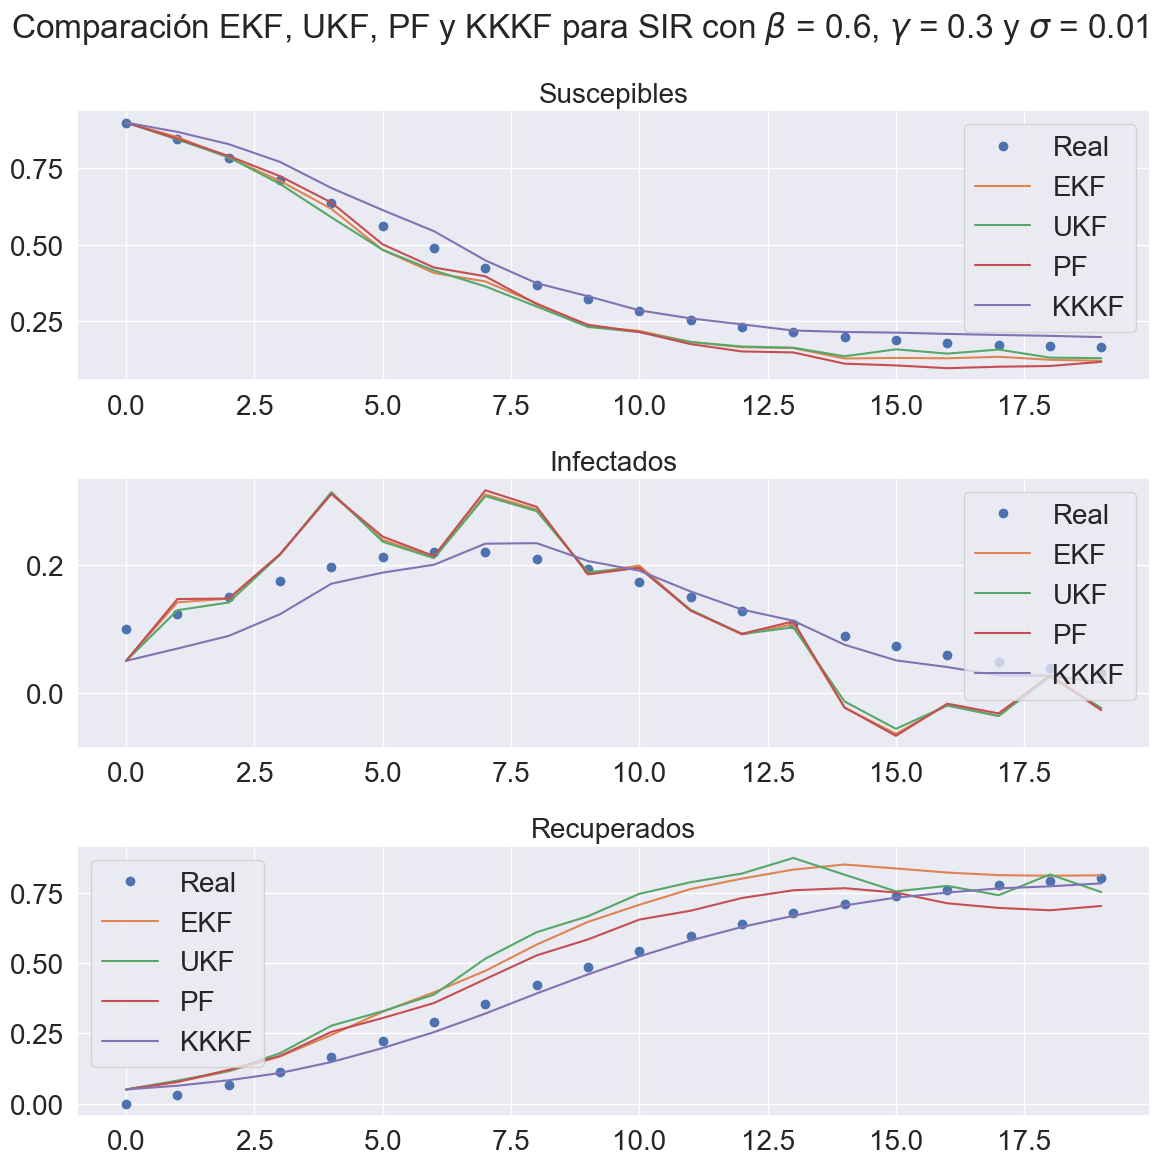

In [27]:
# Testeo para modelo SIR

np.random.seed(42)

# Covarianzas del ruido
sigma = 0.01
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 0.6
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_pf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_pf[:, 0], label='PF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_pf[:, 1], label='PF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_pf[:, 2], label='PF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()

plt.suptitle(r'Comparación EKF, UKF, PF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_beta_06.pdf')

In [28]:
# Calcular el error de cada filtro
print('Error EKF')
print(f"S: {np.linalg.norm(x_ekf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ekf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ekf[:, 2] - x[2, :])}")
print('')

print('Error UKF')
print(f"S: {np.linalg.norm(x_ukf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ukf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ukf[:, 2] - x[2, :])}")
print('')

print('Error PF')
print(f"S: {np.linalg.norm(x_pf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_pf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_pf[:, 2] - x[2, :])}")
print('')

print('Error KKKF')
print(f"S: {np.linalg.norm(x_kkkf.T[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_kkkf.T[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_kkkf.T[:, 2] - x[2, :])}")

Error EKF
S: 0.24420878071469002
I: 0.2903861501989738
R: 0.4874296504990521

Error UKF
S: 0.23787382823223965
I: 0.2814940993064725
R: 0.5503053541112176

Error PF
S: 0.27322019587030355
I: 0.29421104799363335
R: 0.35704478437929943

Error KKKF
S: 0.1411041120063277
I: 0.12998873043019318
R: 0.10361675407744174


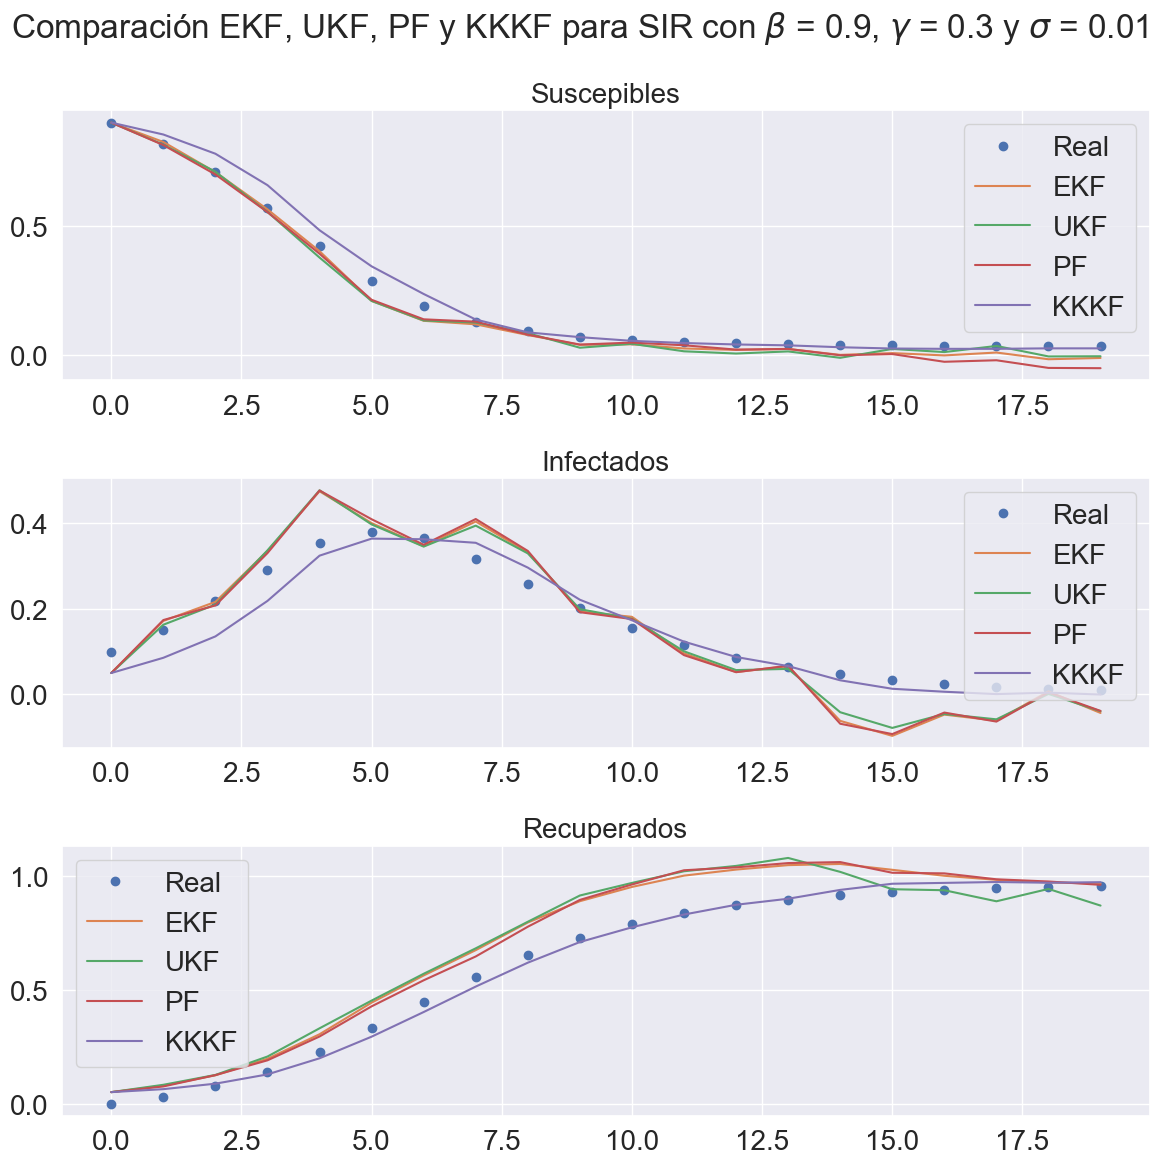

In [29]:
# Testeo para modelo SIR

np.random.seed(42)

# Covarianzas del ruido
sigma = 0.01
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 0.9
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_pf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_pf[:, 0], label='PF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_pf[:, 1], label='PF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_pf[:, 2], label='PF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()

plt.suptitle(r'Comparación EKF, UKF, PF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_beta_09.pdf')

In [30]:
# Calcular el error de cada filtro
print('Error EKF')
print(f"S: {np.linalg.norm(x_ekf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ekf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ekf[:, 2] - x[2, :])}")
print('')

print('Error UKF')
print(f"S: {np.linalg.norm(x_ukf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ukf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ukf[:, 2] - x[2, :])}")
print('')

print('Error PF')
print(f"S: {np.linalg.norm(x_pf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_pf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_pf[:, 2] - x[2, :])}")
print('')

print('Error KKKF')
print(f"S: {np.linalg.norm(x_kkkf.T[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_kkkf.T[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_kkkf.T[:, 2] - x[2, :])}")

Error EKF
S: 0.14860403362136007
I: 0.2807722412241727
R: 0.48656267146512344

Error UKF
S: 0.15328701209429865
I: 0.259031933532808
R: 0.5245987844069261

Error PF
S: 0.18908565003685585
I: 0.28373852233203833
R: 0.48709651349184757

Error KKKF
S: 0.15513173474556594
I: 0.15739838117855479
R: 0.12555591066211216


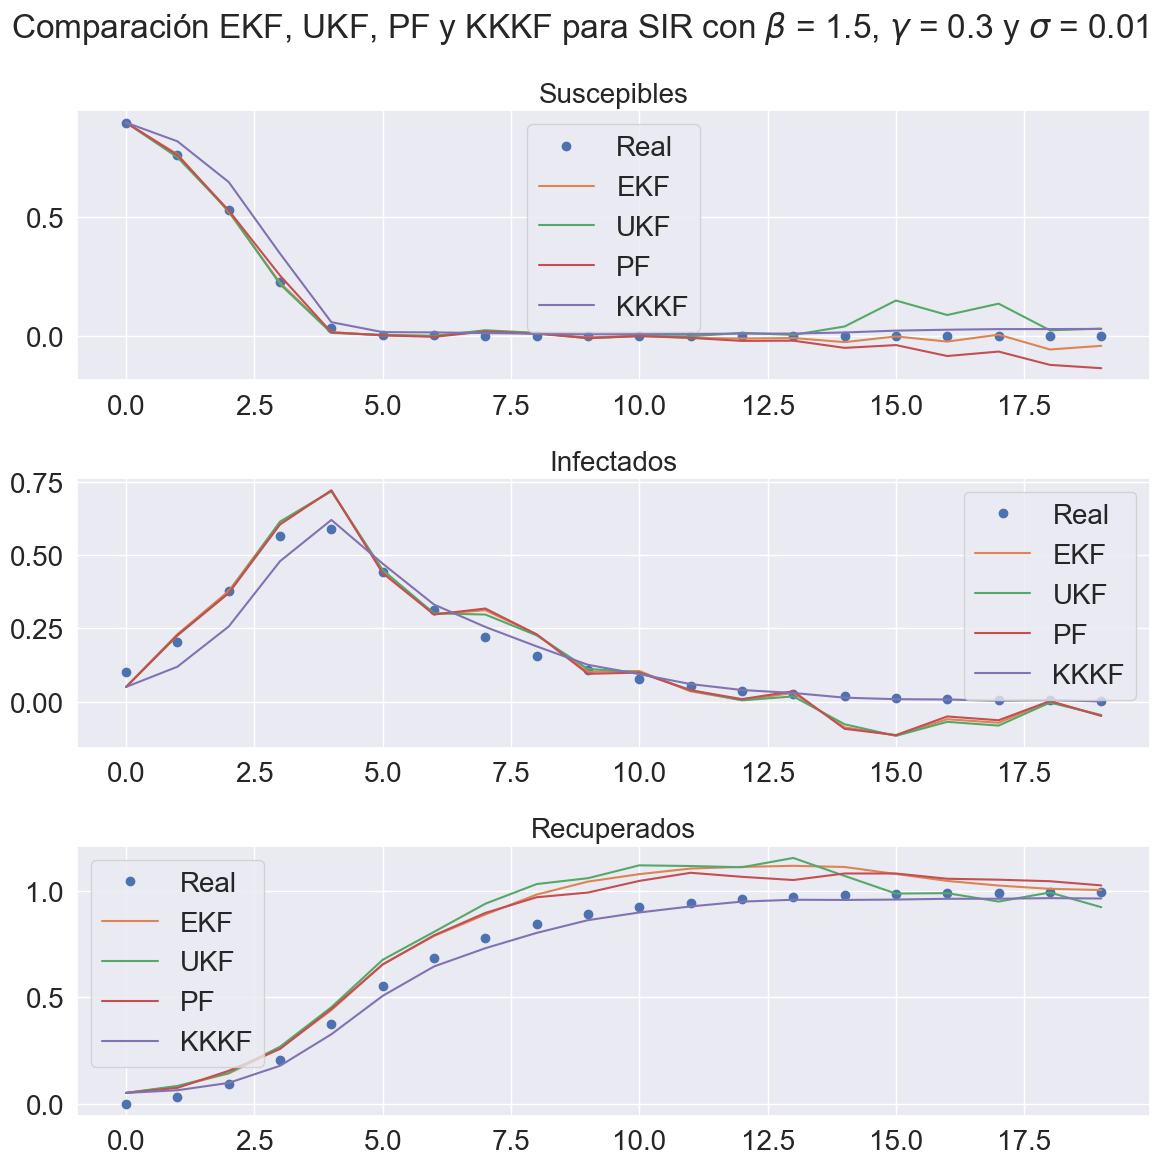

In [31]:
# Testeo para modelo SIR

np.random.seed(42)

# Covarianzas del ruido
sigma = 0.01
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 1.5
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_pf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_pf[:, 0], label='PF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_pf[:, 1], label='PF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_pf[:, 2], label='PF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()

plt.suptitle(r'Comparación EKF, UKF, PF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_beta_15.pdf')

In [32]:
# Calcular el error de cada filtro
print('Error EKF')
print(f"S: {np.linalg.norm(x_ekf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ekf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ekf[:, 2] - x[2, :])}")
print('')

print('Error UKF')
print(f"S: {np.linalg.norm(x_ukf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_ukf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_ukf[:, 2] - x[2, :])}")
print('')

print('Error PF')
print(f"S: {np.linalg.norm(x_pf[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_pf[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_pf[:, 2] - x[2, :])}")
print('')

print('Error KKKF')
print(f"S: {np.linalg.norm(x_kkkf.T[:, 0] - x[0, :])}")
print(f"I: {np.linalg.norm(x_kkkf.T[:, 1] - x[1, :])}")
print(f"R: {np.linalg.norm(x_kkkf.T[:, 2] - x[2, :])}")

Error EKF
S: 0.08847349051496224
I: 0.2833828732230589
R: 0.4671077820078544

Error UKF
S: 0.2296320250137911
I: 0.2787744580041289
R: 0.5294805553326074

Error PF
S: 0.22918226938868047
I: 0.2815536512947738
R: 0.4041900331055178

Error KKKF
S: 0.19059294176332695
I: 0.19340429850833224
R: 0.14349276586458581


### **Algoritmo de estimación de parámetros**

In [617]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x):
    S, I, R, beta, gamma = x 
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I,
        0*S, 
        0*I
    ])

# Observación
g = lambda x: np.array([x[1]])

# Parámetros
beta = 1.3
gamma = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0, beta, gamma])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas 
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 1, 1])
R = sigma*np.eye(ny)

# Distibución Dirichlet en las primera 3 y uniforme en las otras 2
class DirichletUniform(stats.rv_continuous):
    def __init__(self, alpha, beta_lim, gamma_lim, momtype=1, a=None, b=None, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, seed=None):
        super().__init__(momtype, a, b, xtol, badvalue, name, longname, shapes, seed)
        self.alpha = alpha
        self.beta_lim = beta_lim
        self.gamma_lim = gamma_lim
    
    def rvs(self, size=1):
        x = stats.dirichlet(self.alpha).rvs(size=size)
        y1 = stats.uniform(self.beta_lim[0], self.beta_lim[1]).rvs(size=size)
        y2 = stats.uniform(self.gamma_lim[0], self.gamma_lim[1]).rvs(size=size)

        return np.vstack([x.T, y1, y2]).T
    
X_dist = DirichletUniform(np.array([1, 1, 1]), [0.5, 1.5], [0.1, 0.5])
dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)
dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

# Número de dimensiones de aproximación
N = 200

# Número de iteraciones
iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1]) 
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)


In [618]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C

# X_ = X_dist.rvs(N)
# y_ = f(X_.T).T

# # Definir el kernel de Matérn con un length scale inicial
# kernel = C(1, (1e-5, 1e5)) * Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=0.2)

# # Crear el modelo de proceso Gaussiano
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# # Ajustar el modelo a los datos
# gp.fit(X_, y_)

# # Obtener el kernel optimizado
# optimized_kernel = gp.kernel_
# opt_ls = gp.kernel_.k2.length_scale

# print("Kernel optimizado:", optimized_kernel)
# print("Length scale óptimo:", gp.kernel_.k2.length_scale)
# print("Verosimilitud:", gp.log_marginal_likelihood(gp.kernel_.theta))

In [619]:
def param_estim(x0_, n_iters):
    # Prior para la covarianza
    P0 = np.diag([0.001, 0.001, 0.001, 1, 1])

    # Condición inicial prior
    x0_prior = stats.multivariate_normal(mean=x0_, cov=P0)

    # Distribuciones
    X_dist = DirichletUniform(np.array([1, 1, 1]), [0.5, 1.5], [0.1, 0.5])
    dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
    obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)
    dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)
    
    # Inicialización 
    params = np.zeros((n_iters, 2))
    sigmas = np.zeros((n_iters, 2))

    params[0] = x0_[4:5]
    sigmas[0] = np.array([0.01, 0.01])

    # Inicialización para x
    x_ = x0_
    P = P0

    # Iteraciones
    for i in range(1, n_iters):
        x0_prior = stats.multivariate_normal(mean=x_, cov=P)
        dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
        dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

        koopman = KoopmanOperator(kernel_function=Cte(1)*Matern(length_scale=1, nu=0.5), dynamical_system=dyn)

        sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)
        P_ = sol_kkkf.Px_plus[-1]
        P = np.diag([P0[0,0], P0[1,1], P0[2,2], P_[3,3], P_[4,4]])
        sigma_b, sigma_g, z = P[3,3], P[4,4], 1.96
        params[i] = sol_kkkf.x_plus[-1, 3:]
        sigmas[i] = np.array([z*sigma_b, z*sigma_g])
        x_ = np.concatenate([x0_[:3], sol_kkkf.x_plus[-1,3:]])
        #print('Valor estimado para beta: {} ({},{})'.format(x_[3], x_[3]-z*sigma_b, x_[3]+z*sigma_b))
        #print('Valor estimado para gamma: {} ({},{})'.format(x_[4], x_[4]-z*sigma_g, x_[3]+z*sigma_g))

    return params, sigmas

In [620]:
# Parámetros generales
x0_ = np.array([0.9, 0.1, 0, 0.1, 0.1])
n_iters = 300

# Número de núcleos disponibles
num_cores = multiprocessing.cpu_count()

In [621]:
# Sin paralelizar

np.random.seed(42)

# Lista para guardar los resultados
serial_list = []

# Se hace lo mismo por cada cadena
start_serial = time()
for i in tqdm(range(num_cores)):
    serial_list.append(param_estim(x0_, n_iters))

# Tiempo de ejecución
time_serial = time() - start_serial

print("Tiempo de ejecución proceso serial: ", time_serial)

100%|██████████| 8/8 [03:43<00:00, 27.94s/it]

Tiempo de ejecución proceso serial:  223.51505494117737


In [622]:
# Paralelizando

np.random.seed(42)

# Para ingresar a la función
inputs = [[x0_, n_iters]]*num_cores
rg = tqdm(range(len(inputs)))

# Iteraciones paralelizadas
start_parallel = time()
parallel_list = Parallel(n_jobs=num_cores)(
    delayed(param_estim)(*(inputs[i])) for i in rg)

# Tiempo de ejecución
time_parallel = time() - start_parallel

print("Tiempo de ejecución proceso paralelo: ", time_parallel)

100%|██████████| 8/8 [00:00<00:00, 42.32it/s]


Tiempo de ejecución proceso paralelo:  69.38716125488281


In [623]:
np.random.seed(42)

# Solución del filtro con los parámetros estimados
x0_prior = stats.multivariate_normal(
    mean=np.concatenate([x0[:3], parallel_list[0][0][-1]]), 
    cov=0.001*np.eye(5)
    )

X_dist = DirichletUniform(np.array([1, 1, 1]), [0.5, 1.5], [0.1, 0.5])
dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)
dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

# Operador de Koopman
koopman = KoopmanOperator(kernel_function=Cte(1)*Matern(length_scale=1, nu=0.5), dynamical_system=dyn)

sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)

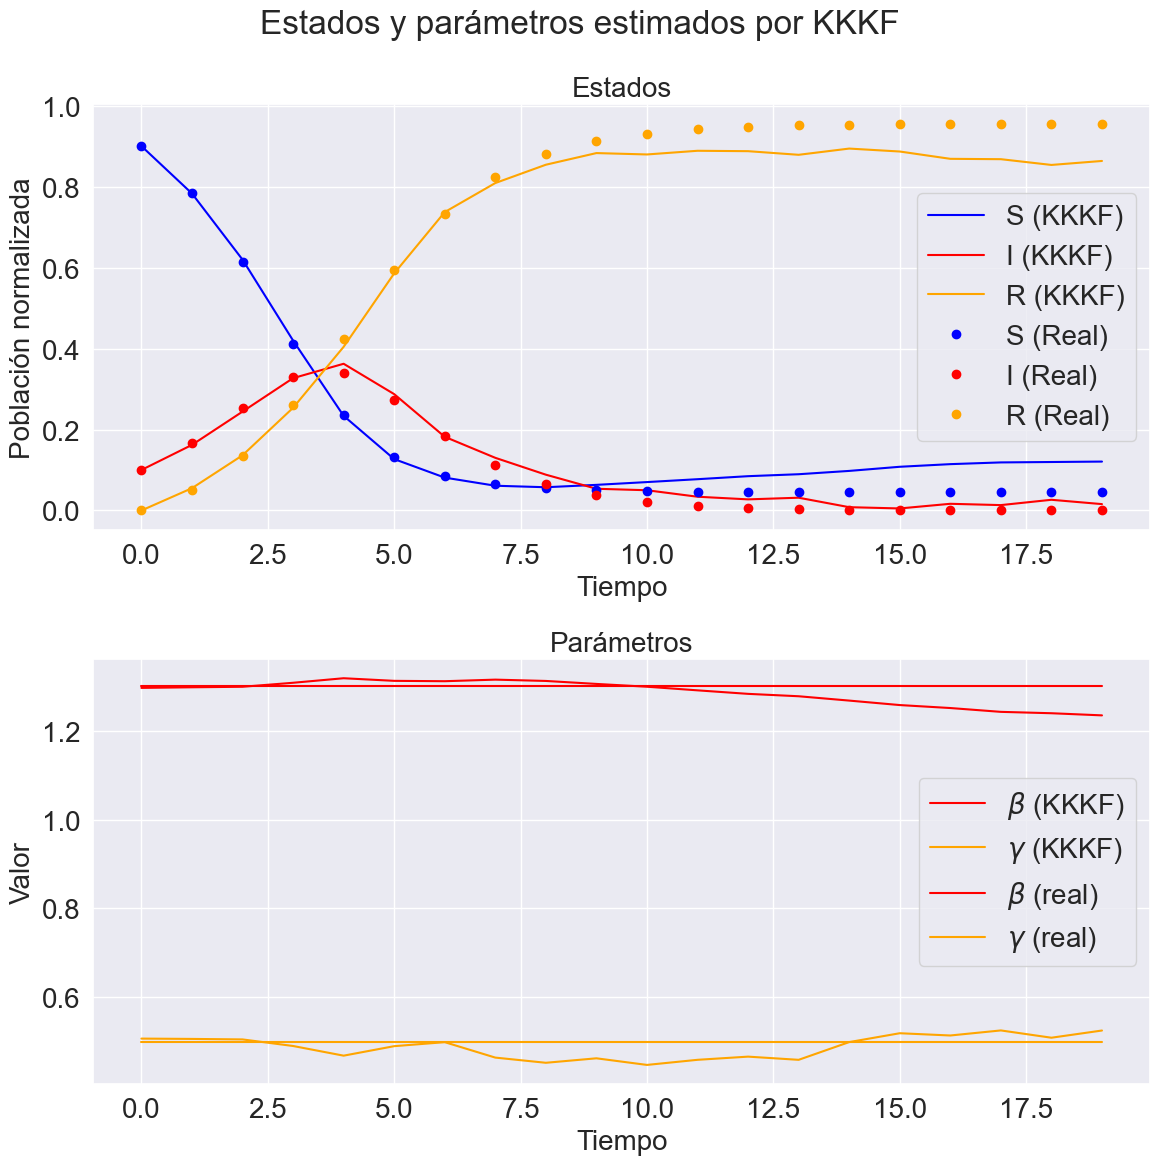

In [624]:
# Gráfico
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].plot(sol_kkkf.x_plus[:, 0], label='S (KKKF)', c='blue')
ax[0].plot(sol_kkkf.x_plus[:, 1], label='I (KKKF)', c='red')
ax[0].plot(sol_kkkf.x_plus[:, 2], label='R (KKKF)', c='orange')

ax[0].plot(x[0], 'o', label='S (Real)', c='blue')
ax[0].plot(x[1], 'o', label='I (Real)', c='red')
ax[0].plot(x[2], 'o', label='R (Real)', c='orange')
ax[0].set_title('Estados')
ax[0].legend()
ax[0].set_xlabel('Tiempo')
ax[0].set_ylabel('Población normalizada')

ax[1].plot(sol_kkkf.x_plus[:, 3], label=r'$\beta$ (KKKF)', c='red')
ax[1].plot(sol_kkkf.x_plus[:, 4], label=r'$\gamma$ (KKKF)', c='orange')
ax[1].plot(iters*[beta], label=r'$\beta$ (real)', c='red')
ax[1].plot(iters*[gamma], label=r'$\gamma$ (real)', c='orange')
ax[1].set_title('Parámetros')
ax[1].legend()
ax[1].set_xlabel('Tiempo')
ax[1].set_ylabel('Valor')

fig.suptitle(r'Estados y parámetros estimados por KKKF')
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_params.pdf')

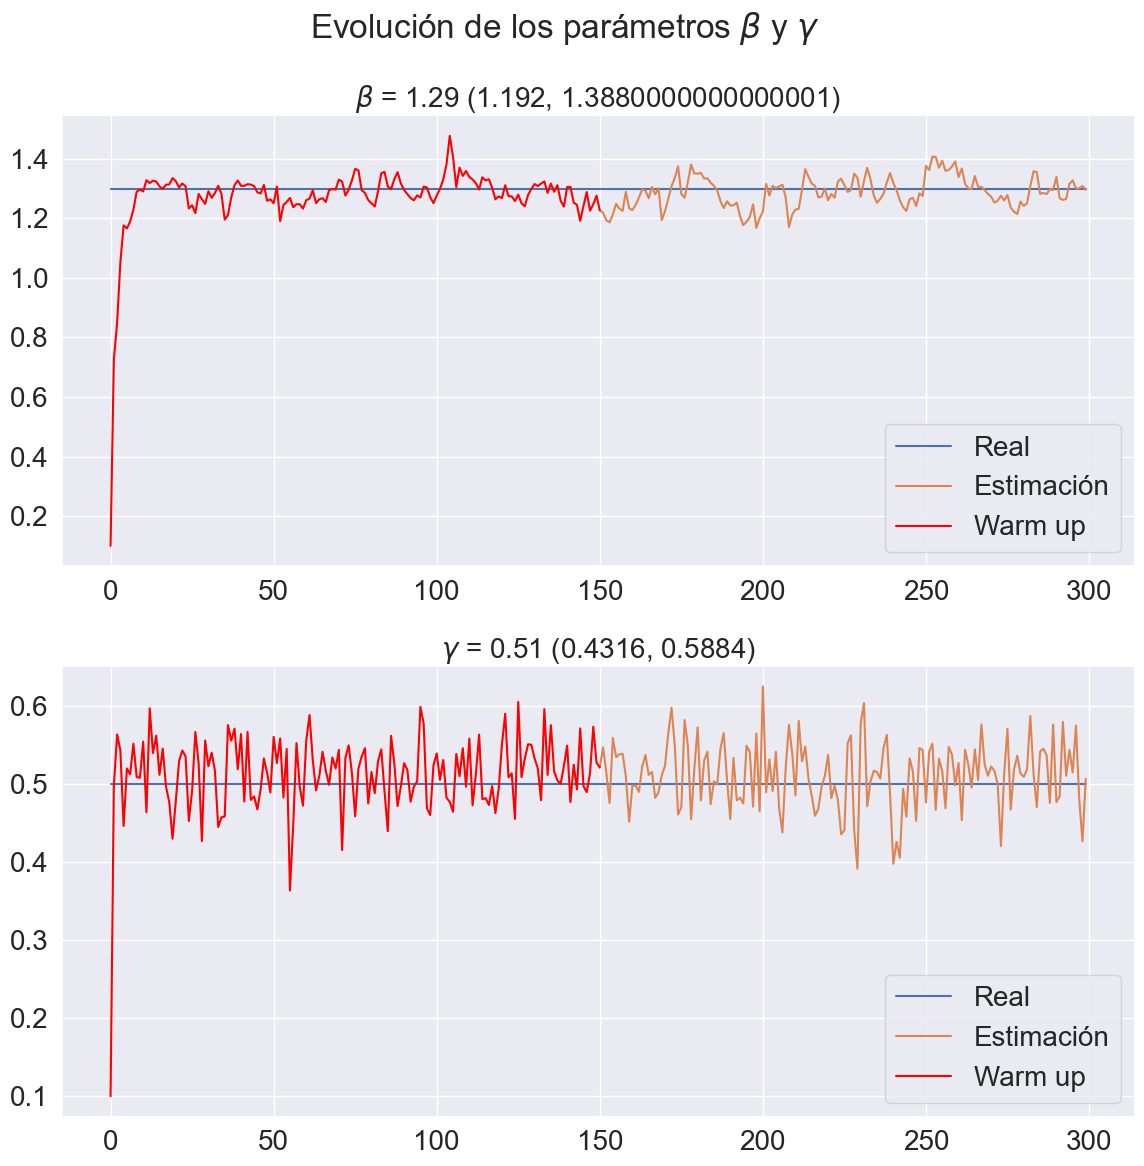

In [625]:
# Parametros
params = parallel_list[0][0]

# Tamaño del intervalo de confianza
alpha = 0.05
z = stats.norm.ppf(1-alpha/2).round(2)

# Nos quedamos solo con algunas para hacer la estimación del parámetro
warmup = int(0.5*n_iters)

# Estimación sin contar las iteraciones de warmup, redondeado
params_est = np.round(np.mean(params[warmup:], axis=0), 2)
sigmas_est = np.round(np.std(params[warmup:], axis=0), 2)

# Gráfico de la evolución del parámetro
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].plot([beta]*n_iters, label='Real')
ax[0].plot(range(warmup, n_iters), params[warmup:, 0], label='Estimación')
ax[0].plot(range(warmup+1), params[:warmup+1, 0], label='Warm up', c='red')
#ax[0].fill_between(np.arange(it), params[:, 0] - z*sigmas[:, 0], params[:, 0] + z*sigmas[:, 0], alpha=0.3)
ax[0].set_title(r'$\beta$ = {} ({}, {})'.format(params_est[0], params_est[0]-z*sigmas_est[0], params_est[0]+z*sigmas_est[0]))
ax[0].legend()

ax[1].plot([gamma]*n_iters, label='Real')
ax[1].plot(range(warmup, n_iters), params[warmup:, 1], label='Estimación')
ax[1].plot(range(warmup+1), params[:warmup+1, 1], label='Warm up', c='red')

#ax[1].fill_between(np.arange(it), params[:, 1] - z*sigmas[:, 1], params[:, 1] + z*sigmas[:, 1], alpha=0.3)
ax[1].set_title(r'$\gamma$ = {} ({}, {})'.format(params_est[1], params_est[1]-z*sigmas_est[1], params_est[1]+z*sigmas_est[1]))
ax[1].legend()

plt.suptitle(r'Evolución de los parámetros $\beta$ y $\gamma$')
plt.tight_layout() 
plt.savefig(img_path+'nonlinear_filters_sir_params_evolution.pdf')

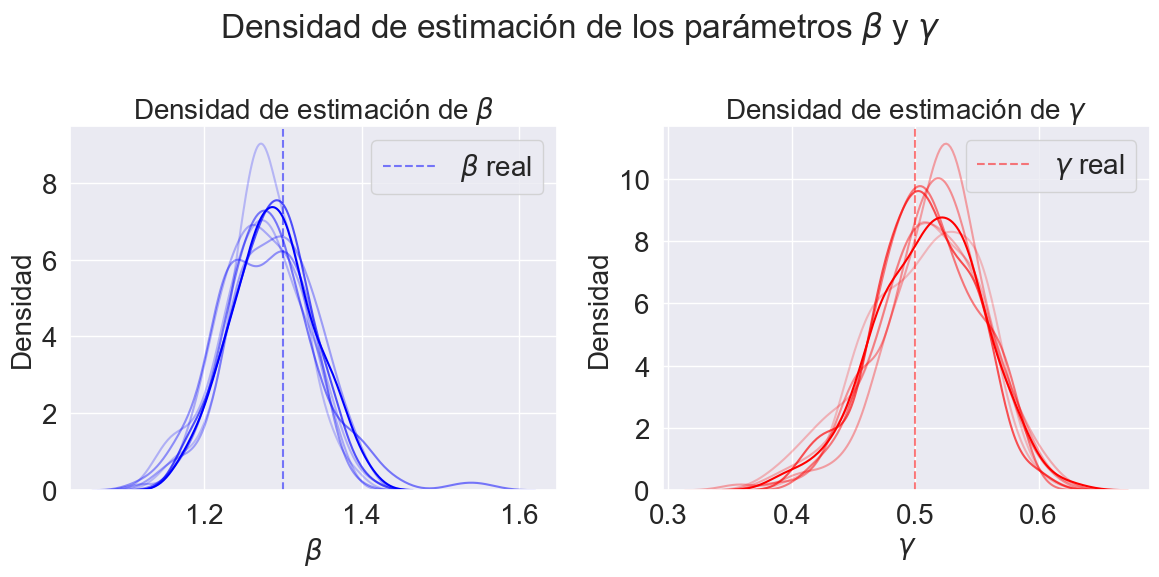

In [626]:
# Evitar warnings
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(len(parallel_list)):
    data = pd.DataFrame(parallel_list[i][0][warmup:], columns=[r'$\beta$', r'$\gamma$'])
    sns.kdeplot(data[r'$\beta$'], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(data[r'$\gamma$'], ax=ax[1], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(beta, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

fig.suptitle(r'Densidad de estimación de los parámetros $\beta$ y $\gamma$')
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_params_density.pdf')

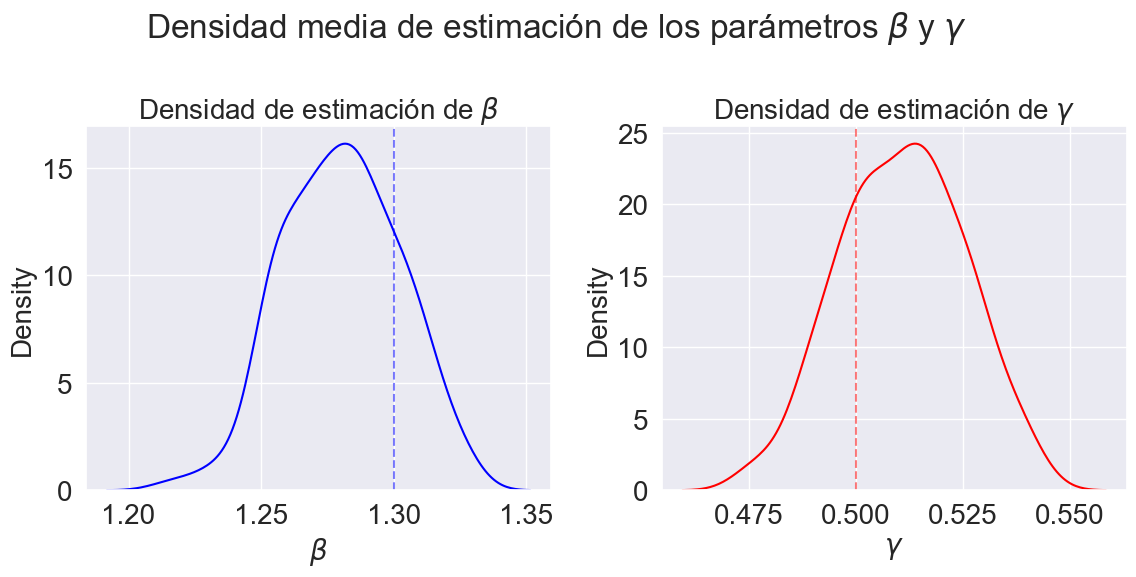

In [627]:
# Cadena media
mean_density = np.mean([parallel_list[i][0][warmup:] for i in range(len(parallel_list))], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(mean_density[:, 0], ax=ax[0], color='blue')
sns.kdeplot(mean_density[:, 1], ax=ax[1], color='red')

ax[0].axvline(beta, color='blue', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\beta$')
ax[0].set_xlabel(r'$\beta$')

ax[1].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\gamma$')
ax[1].set_xlabel(r'$\gamma$')

fig.suptitle(r'Densidad media de estimación de los parámetros $\beta$ y $\gamma$')
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_params_density_mean.pdf')

### **Estimación de parámetros modelo con recuperación**

In [628]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x):
    S, I, R, alpha, beta, gamma = x 
    return x + np.array([
        -beta*S*I + alpha*R,
        beta*S*I - gamma*I,
        gamma*I - alpha*R,
        0*S,
        0*S, 
        0*S
    ])

# Observación
g = lambda x: np.array([x[1]])

# Parámetros
alpha = 0.2
beta = 1.4
gamma = 0.4

# Condición inicial
x0 = np.array([0.9, 0.1, 0, alpha, beta, gamma])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas 
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 10, 10, 10])
R = np.diag([0.01])

# Distibución Dirichlet en las primera 3 y uniforme en las otras 3
class DirichletUniform(stats.rv_continuous):
    def __init__(self, alpha, alpha_lim, beta_lim, gamma_lim, momtype=1, a=None, b=None, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, seed=None):
        super().__init__(momtype, a, b, xtol, badvalue, name, longname, shapes, seed)
        self.alpha = alpha
        self.alpha_lim = alpha_lim
        self.beta_lim = beta_lim
        self.gamma_lim = gamma_lim
    
    def rvs(self, size=1):
        x = stats.dirichlet(self.alpha).rvs(size=size)
        y1 = stats.uniform(self.alpha_lim[0], self.alpha_lim[1]).rvs(size=size)
        y2 = stats.uniform(self.beta_lim[0], self.beta_lim[1]).rvs(size=size)
        y3 = stats.uniform(self.gamma_lim[0], self.gamma_lim[1]).rvs(size=size)

        return np.vstack([x.T, y1, y2, y3]).T
    
X_dist = DirichletUniform(np.array([1, 1, 1]), [0.1, 1.0], [0.1, 1.5], [0.1, 1.0])
dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)
dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

# Número de dimensiones de aproximación
N = 200

# Número de iteraciones
iters = 10

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1]) 
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

In [629]:
def param_estim(x0_, n_iters):
    # Prior covarianza inicial
    P0 = np.diag([0.01, 0.01, 0.01, 10, 10, 10])    

    # Condición inicial prior
    x0_prior = stats.multivariate_normal(mean=x0_, cov=P0)

    # Distribuciones
    X_dist = DirichletUniform(np.array([1, 1, 1]), [0.1, 1.], [0.1, 1.5], [0.1, 0.5])
    dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
    obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)
    dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

    # Operador de Koopman
    koopman = KoopmanOperator(kernel_function=Matern(length_scale=150, nu=0.5), dynamical_system=dyn)

    # Inicialización 
    params = np.zeros((n_iters, 3))
    sigmas = np.zeros((n_iters, 3))

    params[0] = x0_[3:6]
    sigmas[0] = np.array([0.01, 0.01, 0.01])

    # Inicialización para x
    x_ = x0_
    P = P0

    # Iteraciones
    for i in range(1, n_iters):
        x0_prior = stats.multivariate_normal(mean=x_, cov=P)
        dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
        dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)
        koopman = KoopmanOperator(kernel_function=Matern(length_scale=150, nu=0.5), dynamical_system=dyn)

        sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)
        P_ = sol_kkkf.Px_plus[-1]
        P = np.diag([P0[0,0], P0[1,1], P0[2,2], P_[3,3], P_[4,4], P_[5,5]])
        sigma_a, sigma_b, sigma_g, z = P[3,3], P[4,4], P[5,5], 1.96
        params[i] = sol_kkkf.x_plus[-1, 3:]
        sigmas[i] = np.array([z*sigma_a, z*sigma_b, z*sigma_g])
        x_ = np.concatenate([x0_[:3], sol_kkkf.x_plus[-1,3:]])

    return params, sigmas

In [630]:
# Parámetros generales
x0_ = np.array([0.9, 0.1, 0, 0.1, 0.1, 0.1])
n_iters = 500

# Número de núcleos disponibles
num_cores = multiprocessing.cpu_count()

In [631]:
# Paralelizando

np.random.seed(42)

# Para ingresar a la función
inputs = [[x0_, n_iters]]*num_cores
rg = tqdm(range(len(inputs)))

# Iteraciones paralelizadas
start_parallel = time()
parallel_list = Parallel(n_jobs=num_cores)(
    delayed(param_estim)(*inputs[i]) for i in rg)

# Tiempo de ejecución
time_parallel = time() - start_parallel

print("Tiempo de ejecución proceso paralelo: ", time_parallel)

100%|██████████| 8/8 [00:00<00:00, 9162.87it/s]


Tiempo de ejecución proceso paralelo:  37.124873876571655


In [632]:
np.random.seed(42)

# Solución del filtro con los parámetros estimados
x0_prior = stats.multivariate_normal(
    mean=np.concatenate([x0[:3], parallel_list[0][0][-1]]), 
    cov=0.01*np.eye(nx)
    )

X_dist = DirichletUniform(np.array([1, 1, 1]), [0.1, 1.], [0.1, 1.5], [0.1, 0.5])
dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)
dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

# Operador de Koopman
koopman = KoopmanOperator(kernel_function=Matern(length_scale=1e3, nu=0.5), dynamical_system=dyn)

sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)

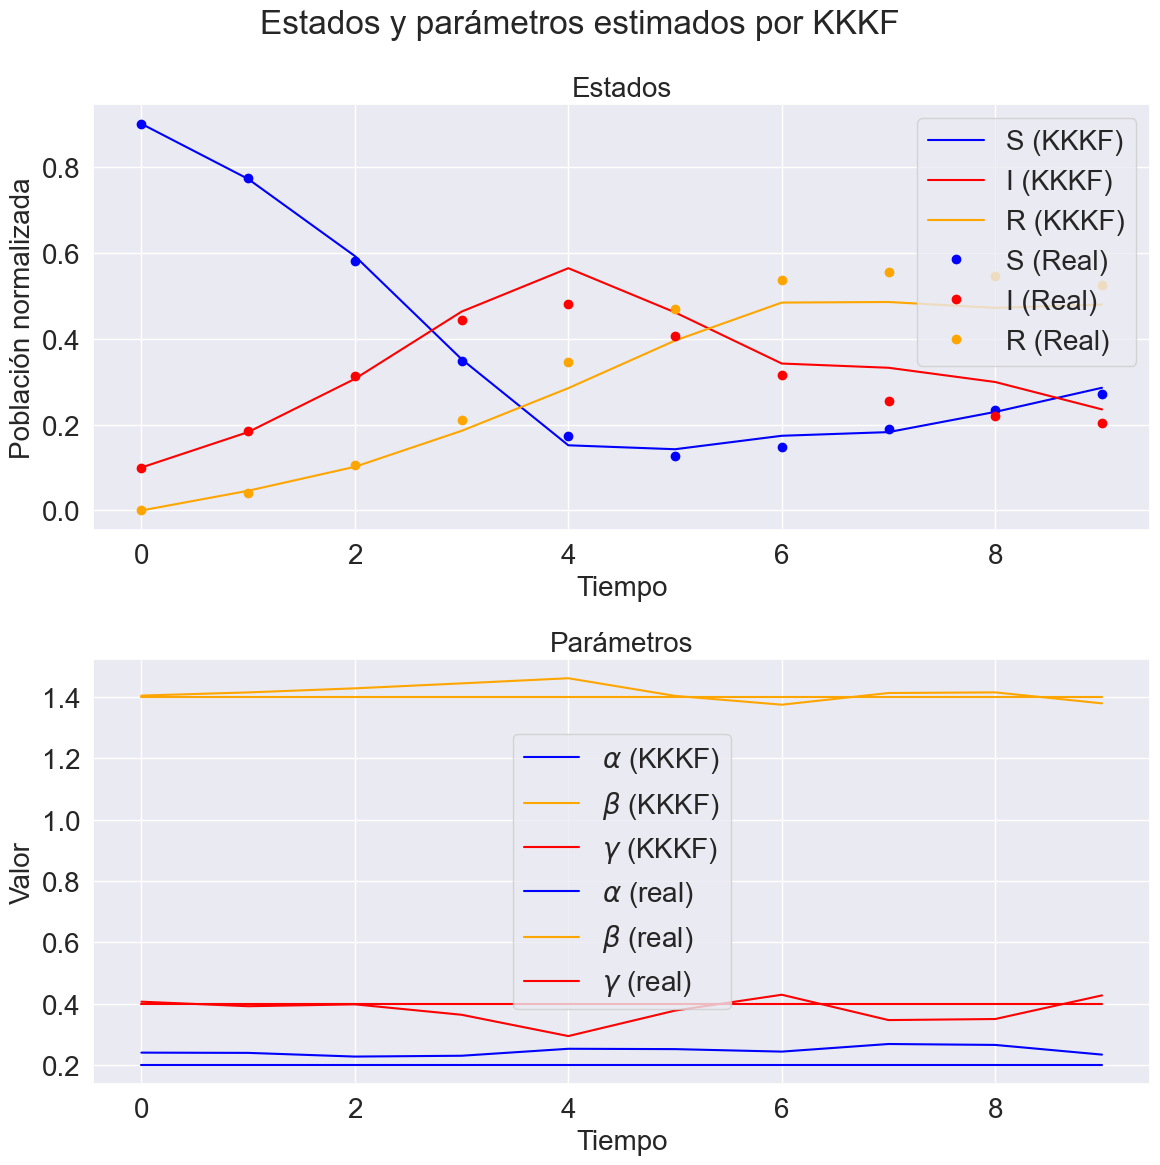

In [633]:
# Gráfico
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].plot(sol_kkkf.x_plus[:, 0], label='S (KKKF)', c='blue')
ax[0].plot(sol_kkkf.x_plus[:, 1], label='I (KKKF)', c='red')
ax[0].plot(sol_kkkf.x_plus[:, 2], label='R (KKKF)', c='orange')

ax[0].plot(x[0], 'o', label='S (Real)', c='blue')
ax[0].plot(x[1], 'o', label='I (Real)', c='red')
ax[0].plot(x[2], 'o', label='R (Real)', c='orange')
ax[0].set_title('Estados')
ax[0].legend()
ax[0].set_xlabel('Tiempo')
ax[0].set_ylabel('Población normalizada')

ax[1].plot(sol_kkkf.x_plus[:, 3], label=r'$\alpha$ (KKKF)', c='blue')
ax[1].plot(sol_kkkf.x_plus[:, 4], label=r'$\beta$ (KKKF)', c='orange')
ax[1].plot(sol_kkkf.x_plus[:, 5], label=r'$\gamma$ (KKKF)', c='red')
ax[1].plot(iters*[alpha], label=r'$\alpha$ (real)', c='blue')
ax[1].plot(iters*[beta], label=r'$\beta$ (real)', c='orange')
ax[1].plot(iters*[gamma], label=r'$\gamma$ (real)', c='red')
ax[1].set_title('Parámetros')
ax[1].legend()
ax[1].set_xlabel('Tiempo')
ax[1].set_ylabel('Valor')

fig.suptitle(r'Estados y parámetros estimados por KKKF')
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_rec_params.pdf')

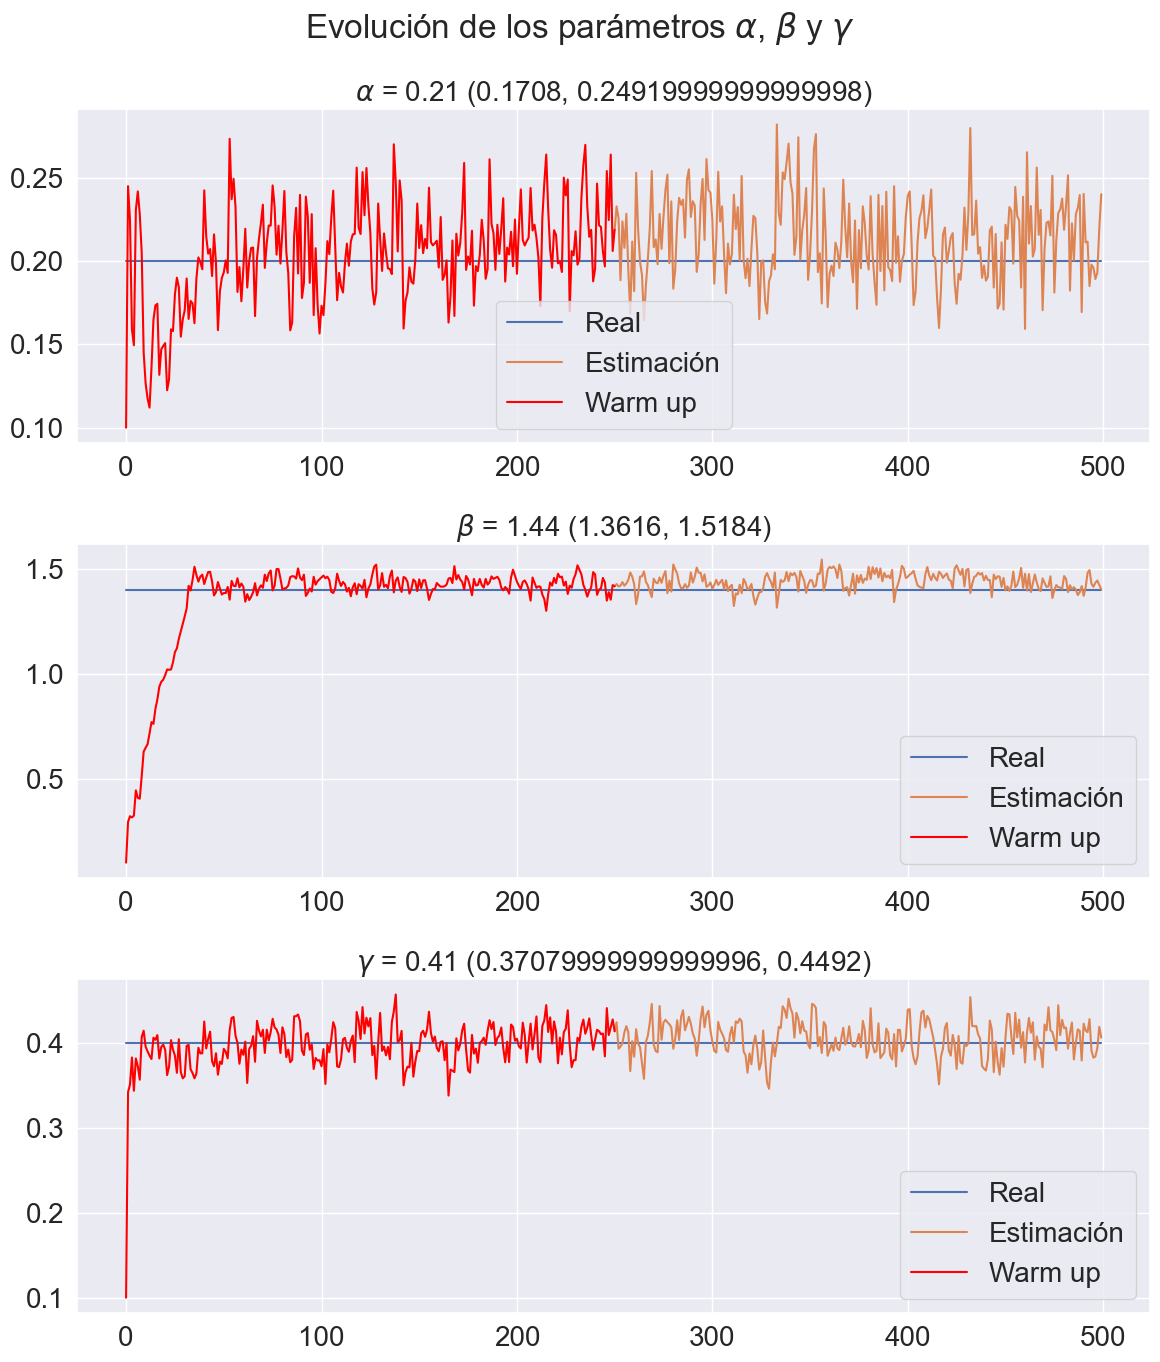

In [634]:
# Parametros
params = parallel_list[0][0]

# Tamaño del intervalo de confianza
alpha_ = 0.05
z = stats.norm.ppf(1-alpha_/2).round(2)

# Nos quedamos solo con algunas para hacer la estimación del parámetro
warmup = int(0.5*n_iters)

# Estimación sin contar las iteraciones de warmup, redondeado
params_est = np.round(np.mean(params[warmup:], axis=0), 2)
sigmas_est = np.round(np.std(params[warmup:], axis=0), 2)

# Gráfico de la evolución del parámetro
fig, ax = plt.subplots(3, 1, figsize=(12, 14))

ax[0].plot([alpha]*n_iters, label='Real')
ax[0].plot(range(warmup, n_iters), params[warmup:, 0], label='Estimación')
ax[0].plot(range(warmup+1), params[:warmup+1, 0], label='Warm up', c='red')
ax[0].set_title(r'$\alpha$ = {} ({}, {})'.format(params_est[0], params_est[0]-z*sigmas_est[0], params_est[0]+z*sigmas_est[0]))
ax[0].legend()

ax[1].plot([beta]*n_iters, label='Real')
ax[1].plot(range(warmup, n_iters), params[warmup:, 1], label='Estimación')
ax[1].plot(range(warmup+1), params[:warmup+1, 1], label='Warm up', c='red')
ax[1].set_title(r'$\beta$ = {} ({}, {})'.format(params_est[1], params_est[1]-z*sigmas_est[1], params_est[1]+z*sigmas_est[1]))
ax[1].legend()

ax[2].plot([gamma]*n_iters, label='Real')
ax[2].plot(range(warmup, n_iters), params[warmup:, 2], label='Estimación')
ax[2].plot(range(warmup+1), params[:warmup+1, 2], label='Warm up', c='red')
ax[2].set_title(r'$\gamma$ = {} ({}, {})'.format(params_est[2], params_est[2]-z*sigmas_est[2], params_est[2]+z*sigmas_est[2]))
ax[2].legend()

plt.suptitle(r'Evolución de los parámetros $\alpha$, $\beta$ y $\gamma$')
plt.tight_layout() 
plt.savefig(img_path+'nonlinear_filters_sir_rec_params_evolution.pdf')

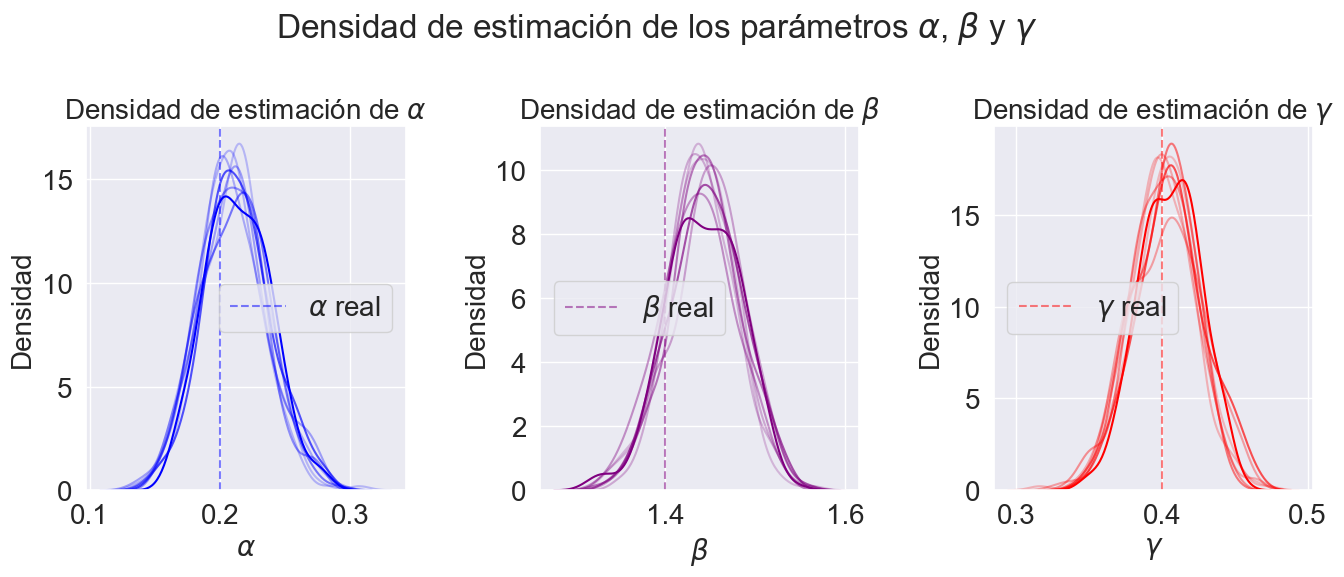

In [635]:
# Evitar warnings
import warnings
warnings.filterwarnings("ignore")

# Gráfico de densidades
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for i in range(len(parallel_list)):
    data = pd.DataFrame(parallel_list[i][0][warmup:], columns=[r'$\alpha$', r'$\beta$', r'$\gamma$'])
    sns.kdeplot(data[r'$\alpha$'], ax=ax[0], color='blue', alpha=1/(i*0.5+1))
    sns.kdeplot(data[r'$\beta$'], ax=ax[1], color='purple', alpha=1/(i*0.5+1))
    sns.kdeplot(data[r'$\gamma$'], ax=ax[2], color='red', alpha=1/(i*0.5+1))

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Densidad')
ax[0].legend()

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Densidad')
ax[1].legend()

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')
ax[2].set_ylabel('Densidad')
ax[2].legend()

fig.suptitle(r'Densidad de estimación de los parámetros $\alpha$, $\beta$ y $\gamma$')
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_rec_params_density.pdf')

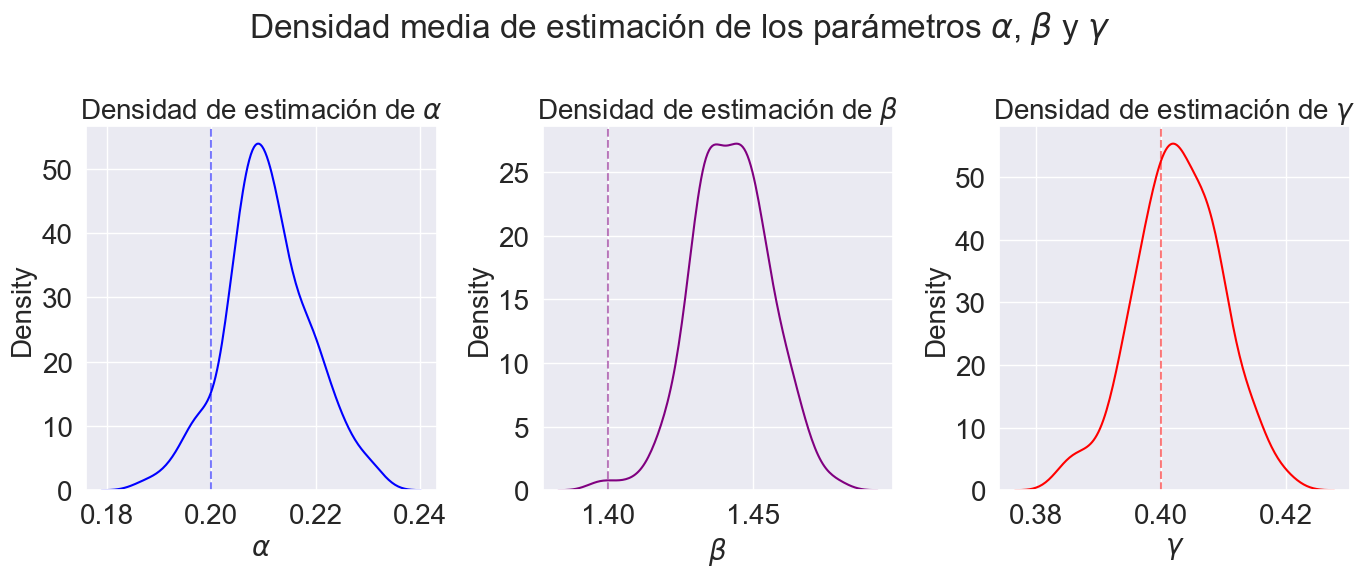

In [636]:
# Cadena media
mean_density = np.mean([parallel_list[i][0][warmup:] for i in range(len(parallel_list))], axis=0)

fig, ax = plt.subplots(1, 3, figsize=(14, 6))

sns.kdeplot(mean_density[:, 0], ax=ax[0], color='blue')
sns.kdeplot(mean_density[:, 1], ax=ax[1], color='purple')
sns.kdeplot(mean_density[:, 2], ax=ax[2], color='red')

ax[0].axvline(alpha, color='blue', linestyle='--', label=r'$\alpha$ real', alpha=0.5)
ax[0].set_title(r'Densidad de estimación de $\alpha$')
ax[0].set_xlabel(r'$\alpha$')

ax[1].axvline(beta, color='purple', linestyle='--', label=r'$\beta$ real', alpha=0.5)
ax[1].set_title(r'Densidad de estimación de $\beta$')
ax[1].set_xlabel(r'$\beta$')

ax[2].axvline(gamma, color='red', linestyle='--', label=r'$\gamma$ real', alpha=0.5)
ax[2].set_title(r'Densidad de estimación de $\gamma$')
ax[2].set_xlabel(r'$\gamma$')

fig.suptitle(r'Densidad media de estimación de los parámetros $\alpha$, $\beta$ y $\gamma$')
plt.tight_layout()
plt.savefig(img_path+'nonlinear_filters_sir_rec_params_density_mean.pdf')

### Modelo de estimación no aditivo

In [926]:
np.random.seed(42)

# Función de dinámica
def f(x, w):
    return x + w

def F(x):
    return np.mean(f(x.reshape((len(x),1)), dyn_dist.rvs(300)), axis=1)

# Función de observación
def g(x, v):
    return stats.expon(scale=x).ppf(v)

def G(x):
    return np.mean(g(x.reshape((len(x),1)), obs_dist.rvs(300)), axis=1)

# Parámetros
x0 = np.array([0.6])

# Distribuciones
class VectorUniform(stats.rv_continuous):
    def __init__(self, lb, ub, momtype=1, a=None, b=None, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, seed=None):
        super().__init__(momtype, a, b, xtol, badvalue, name, longname, shapes, seed)
        self.lb = lb
        self.ub = ub
    
    def rvs(self, size=1):
        return np.array([stats.uniform(self.lb, self.ub).rvs(size=size)])

class DynDist:
    def __init__(self):
        pass

    def rvs(self, size=1):
        return f(x, dyn_dist.rvs(size=size)) - F(x)

class ObsDist:
    def __init__(self):
        pass

    def rvs(self, x, size=1):
        return g(x, obs_dist.rvs(size=size)) - G(x)


X_dist = VectorUniform(0, 2)
dyn_dist = stats.multivariate_normal(mean=np.array([0]), cov=np.array([[0.0001]]))
obs_dist = stats.uniform(0, 1.0)

# Número de dimensiones de aproximación
N = 100

# Número de iteraciones
iters = 200

# Datos sintéticos
x, y = np.zeros((1, iters)), np.zeros((1, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1], dyn_dist.rvs()) 
    y[:, i] = g(x[:, i], obs_dist.rvs()) 

In [951]:
# Función para estimar parámetros
def param_estim(x0_, n_iters):
    # KKKF manual

    # Prior covarianza inicial
    P0 = np.diag([1])

    x0_prior = stats.multivariate_normal(mean=x0_, cov=P0)

    # Kernel
    kernel = Cte(1)*Matern(length_scale=100, nu=0.5)

    X = X_dist.rvs(N)

    phi = lambda x: kernel(x, X.T)[0]

    G_m = kernel(X.T)
    G_inv = np.linalg.inv(G_m)

    # Matrices
    U = kernel(X.T, F(X.T).reshape((1, N)).T) @ G_inv
    B = X @ G_inv
    C = (G(X.T) @ G_inv).reshape((1, N))

    params = np.zeros((n_iters, 1))

    params[0] = x0_

    P = P0 
    x_ = x0_

    for j in range(1, n_iters):
        x0_prior = stats.multivariate_normal(mean=x_, cov=P)
        #dyn_dist = stats.multivariate_normal(mean=np.zeros(1), cov=1*np.eye(1))
        x_koop = np.zeros((iters, 1))
        P_koop = np.zeros((iters, 1, 1))

        z_koop = np.zeros((iters, N))
        Z_koop = np.zeros((iters, N, N))

        x_koop[0] = x_
        P_koop[0] = x0_prior.cov

        z_koop[0] = kernel(x0_, X.T)
        Z_koop[0] = np.cov(np.vstack([phi([x0_prior.rvs()]) for _ in range(100)]).T)

        for i in range(1, iters):
            # Predicción
            x_koop[i] = F(x_koop[i-1])
            Q = np.cov(np.vstack([phi(f(x_koop[i], dyn_dist.rvs())) for _ in range(100)]).T)
            Z_koop[i] = U @ Z_koop[i-1] @ U.T + Q

            # Actualización
            z_koop[i] = kernel(x_koop[i], X.T)
            R = np.array([np.cov(np.vstack([g(x_koop[i], obs_dist.rvs()) for _ in range(100)]).T)]).reshape((1,1))

            K = Z_koop[i] @ C.T @ np.linalg.cholesky(np.linalg.inv(C @ Z_koop[i] @ C.T + R))
            z_koop[i] = z_koop[i] + K @ (y[:, i] - C @ z_koop[i])
            Z_koop[i] = Z_koop[i] - K @ C @ Z_koop[i]

            x_koop[i] = B @ z_koop[i]
            P_koop[i] = B @ Z_koop[i] @ B.T

        P = P_koop[-1]
        x_ = x_koop[-1]
        params[j] = x_

    return params

In [952]:
# Paralelizando

np.random.seed(42)

# Condición inicial prior
x0_ = np.array([0.1])

# Cantidad de iteraciones
n_iters = 100

# Para ingresar a la función
inputs = [[x0_, n_iters]]*num_cores
rg = tqdm(range(len(inputs)))

# Iteraciones paralelizadas
start_parallel = time()
parallel_list = Parallel(n_jobs=num_cores)(
    delayed(param_estim)(*inputs[i]) for i in rg)

# Tiempo de ejecución
time_parallel = time() - start_parallel

print("Tiempo de ejecución proceso paralelo: ", time_parallel)

100%|██████████| 8/8 [00:00<00:00, 988.90it/s]


Tiempo de ejecución proceso paralelo:  18356.408872127533


Text(0.5, 1.0, '$\\lambda$ = 0.63 (0.6186352789152726,0.6413647210847274)')

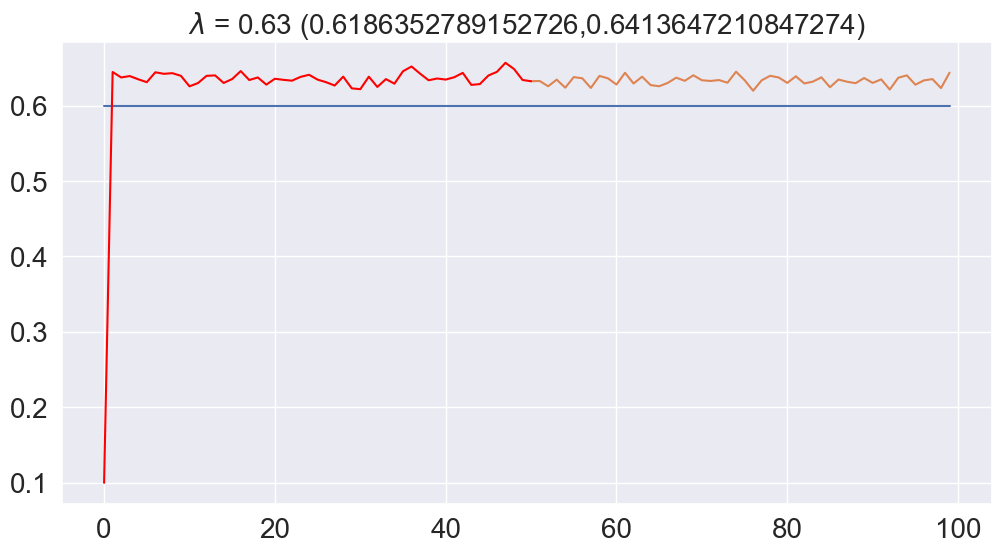

In [953]:
# Evolución del parámetro
params = parallel_list[0]

# Tamaño del intervalo de confianza
alpha = 0.05
z = stats.norm.ppf(1-alpha/2).round(2)

# Nos quedamos solo con algunas para hacer la estimación del parámetro
warmup = int(0.5*n_iters)

# Estimación sin contar las iteraciones de warmup, redondeado
params_est = np.round(np.mean(params[warmup:], axis=0), 2)
sigma = params[warmup:].std()

# Gráfico de la evolución del parámetro
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot([x0]*n_iters, label='Real')
ax.plot(range(warmup, n_iters), params[warmup:], label='Estimación')
ax.plot(range(warmup+1), params[:warmup+1], label='Warm up', c='red')
ax.set_title(r'$\lambda$ = {} ({},{})'.format(params_est[0], params_est[0]-z*sigma, params_est[0]+z*sigma))


In [ ]:
# Gráfico de densidades

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for i in range(len(parallel_list)):
    data = pd.DataFrame(parallel_list[i][warmup:], columns=[r'$\lambda$'])
    sns.kdeplot(data[r'$\lambda$'], ax=ax, color='blue', alpha=1/(i*0.5+1))

ax.axvline(0.1, color='blue', linestyle='--', label=r'$\lambda$ real', alpha=0.5)
ax.set_title(r'Densidad de estimación de $\lambda$')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Densidad')
ax.legend()